Pandemic Lockdown Modelling:  Bayesian optimization using VIPER

GP EI: Newton-CG (exact GP EI Hessian) vs. L-BFGS-B (without Hessian)

https://github.com/purushottamkar/esop

https://arxiv.org/abs/2005.11257


In [1]:
!pip install pyGPGO

In [2]:
## Import modules

import numpy as np
import scipy

import pandas as pd
import matplotlib.pyplot as plt
import pickle
import random
import warnings
import time

from pyGPGO.logger import EventLogger
from pyGPGO.GPGO import GPGO
from pyGPGO.surrogates.GaussianProcess import GaussianProcess
from pyGPGO.acquisition import Acquisition
from pyGPGO.covfunc import squaredExponential, matern52

from collections import OrderedDict
from joblib import Parallel, delayed
from numpy.linalg import slogdet, inv, cholesky, solve
from scipy.optimize import minimize
from scipy.spatial.distance import cdist
from scipy.stats import norm, binned_statistic as binStat
from matplotlib.pyplot import rc
rc('text', usetex=False)

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [3]:
### https://github.com/purushottamkar/esop/utils.py

### https://arxiv.org/abs/2005.11257

### VIPER Model

# Convenient named constants for indices for various parameters pertaining to an individual in the VIPER model
IDX_SUS = 0 # Susceptibility
IDX_VLD = 1 # Viral load
IDX_RLD = 2 # Recovery load
IDX_RST = 3 # Resistance (never changed - intrinsic to the individual)
IDX_X = 4   # X coordinate (only changed if the individual is travelling)
IDX_Y = 5   # Y coordinate (only changed if the individual is travelling)
IDX_STA = 6 # State
IDX_QRN = 7 # Is this individual quarantined or not
IDX_DPR = 8 # Disease progression rate
IDX_TI = 9  # Timestamp of infection (only changed at time of infection)
IDX_TQ = 10 # Timestamp of quarantine
IDX_TR = 11 # Timestamp of recovery/expiry (only changed at time of recovery/expiry)

nParams = 12

sqrt2 = np.sqrt(2)

# Convenient named constants for various states of an individual
# Being quarantined is not a medical state and so it is tracked
# separately (see IDX_QRN above) -- this allows VIPER to quarantine
ST_S = 0	# Susceptible
ST_E = 1	# Exposed
ST_I = 2	# Infectious
ST_R = 3	# Recovered
ST_X = 4	# Expired

nStates = 5

# Convenient named constants useful for reporting stats
SIDX_S = 0	# Number of susceptible but non-recovered individuals
SIDX_E = 1	# Number of exposed individuals
SIDX_I = 2	# Number of infectious individuals
SIDX_Q = 3	# Number of quarantined individuals
SIDX_R = 4	# Number of recovered individuals
SIDX_X = 5	# Number of expired individuals
SIDX_V = 6	# Average virulence of the viral strains in E and I populations
SIDX_EI = 7	# Number of infected individuals
SIDX_D = 8	# Number of individuals infected each day

nStats = 9

# This class provides an encapsulation for the VIPER model as well as methods
# to perform epidemiological simulations under lock-down, quarantining etc
class Population:
	# The base constructor -- almost never used directly
	def __init__( self, N, BIR, BCR, INC, BVL, VMR, QTH, BQP, XTH, BXP, BTR, BTD, BDPR, alphaInit, popIdx, ind, SUS, RST, X, Y ):
		self.N = N
		self.BIR = BIR
		self.BCR = BCR
		self.INC = INC
		self.BVL = BVL
		self.VMR = VMR
		self.QTH = QTH
		self.BQP = BQP
		self.XTH = XTH
		self.BXP = BXP
		self.BTR = BTR
		self.BTD = BTD
		self.BDPR = BDPR
		self.alphaInit = alphaInit
		
		self.popIdx = popIdx
		self.ind = ind
		self.SUS = SUS
		self.RST = RST
		self.X = X
		self.Y = Y
	
	# Constructor that initializes using scalar values alone
	# This provides a generic population with location, SUS, RST values
	# set uniformly randomly. To use India-specific initialization, use
	# the patch provided by the class Demographics (see below and setup.py)
	
	# N: the size of the population before the pandemic began
	# BIR: the (base) probability that a contact event will lead to a successful infection
	# BCR: the (base) contact radius
	# INC: the incubation period for the virus
	# BVL: the base viral load presented in individuals at the end of the exposed period
	# VMR: the rate at which the DPR mutates upon contact
	# QTH: the viral load over which an individual's chances of getting quarantined increase linearly
	# BQP: the (base) quarantining probability for a person with viral load at the QTH threshold
	# XTH: the viral load over which an individual's chances of getting expired increase linearly
	# BXP: the (base) expiry probability for a person with viral load at the XTH threshold
	# BTR: the (base) fraction of population that travels at any time instant
	# BTD: the (base) distance to which people travel
	# BDPR: the (base) disease progression rate for the initial strain of the virus
	# alphaInit: the initial fraction of population that is infected with the virus
	@classmethod
	def valInit( cls, N, BIR = 0.5, BCR = 0.25, INC = 3, BVL = 0.05, VMR = 0.0, QTH = 0.3, BQP = 0.0, XTH = 0.7, BXP = 0.0, BTR = 0.01, BTD = 1.0, BDPR = 0.1, alphaInit = 0.01 ):
		# Give the individuals unique identifiers
		popIdx = np.arange(N)
		
		# Initialize the individuals
		ind = np.zeros( (N, nParams) )

		# Initially no one is infected or quarantined
		ind[ :, IDX_VLD ] = 0
		ind[ :, IDX_RLD ] = 0
		ind[ :, IDX_STA ] = ST_S
		ind[ :, IDX_DPR ] = 0
		ind[ :, IDX_QRN ] = 0
		
		# People have susceptibilities uniformly in a range
		# The patch offered by the Demographics class allows this to be changed
		SUS = np.random.uniform( 0.01, 0.99, (N,) )
		ind[ :, IDX_SUS ] = SUS
		
		# People have resistances uniformly in a range
		# The patch offered by the Demographics class allows this to be changed
		RST = 0.1 * np.random.uniform( 0.01, 0.99, (N,) )
		ind[ :, IDX_RST ] = RST

		# Set their locations uniformly at random within the [0,1] x [0,1] square
		# The patch offered by the Demographics class allows this to be changed
		X = np.random.uniform( 0, 1, (N,) )
		ind[ :, IDX_X ] = X
		Y = np.random.uniform( 0, 1, (N,) )
		ind[ :, IDX_Y ] = Y
		
		# Set the timers to invalid values since nothing has happened yet
		ind[ :, IDX_TI ] = 0
		ind[ :, IDX_TQ ] = 0
		ind[ :, IDX_TR ] = 0
		
		return cls( N, BIR, BCR, INC, BVL, VMR, QTH, BQP, XTH, BXP, BTR, BTD, BDPR, alphaInit, popIdx, ind, SUS, RST, X, Y )
	
	# Constructor that initializes using data loaded from file
	@classmethod
	def fileInit( cls, filename ):
		# Get data from the file
		with open( filename, 'rb' ) as file:
			data = pickle.load( file )
		
		# Create an object out of this data and return it
		return cls( *data )
		
	# Save a copy of this object to a file
	def dump( self, filename ):
		data = ( self.N, self.BIR, self.BCR, self.INC, self.BVL, self.VMR, self.QTH, self.BQP, self.XTH, self.BXP, self.BTR, self.BTD, self.BDPR, self.alphaInit, self.popIdx, self.ind, self.SUS, self.RST, self.X, self.Y )
		with open( filename, 'wb' ) as file:
			pickle.dump( data, file )
			
	# Turn the clock back to before the pandemic started
	def reset( self ):
		# Reinitialize the individuals
		self.ind.fill(0)
		
		# Reset their susceptibilities to their original values (they do change for recovered and expired individuals)
		self.ind[ :, IDX_SUS ] = self.SUS
							 
		# Initially no one is infected or quarantined
		self.ind[ :, IDX_VLD ] = 0
		self.ind[ :, IDX_RLD ] = 0
		self.ind[ :, IDX_STA ] = ST_S
		self.ind[ :, IDX_DPR ] = 0
		self.ind[ :, IDX_QRN ] = 0
							 
		# Reset their resistances to their original value (although they should not have changed)
		self.ind[ :, IDX_RST ] = self.RST
				  
		# Reset their locations
		self.ind[ :, IDX_X ] = self.X
		self.ind[ :, IDX_Y ] = self.Y
				  
		# Reset the timers to a happier time before the pandemic began
		self.ind[ :, IDX_TI ] = 0
		self.ind[ :, IDX_TQ ] = 0
		self.ind[ :, IDX_TR ] = 0
		
	# T: the number of time steps for which to run the simulation
	# LKP: the lock-down policy
	def simulate( self, T, LKP, minimal = False, checkSanity = False ):
		numInfInit = int( self.alphaInit * self.N )
		
		# Randomly select the unfortunate souls who are going to get infected initially
		idxInit = np.random.permutation( self.N )[ : numInfInit ]
		
		# Infect them!
		self.ind[ idxInit, IDX_STA ] = ST_E			# These individuals are incubating right now
		self.ind[ idxInit, IDX_DPR ] = self.BDPR	# The virus has not mutated yet
		self.ind[ idxInit, IDX_TI ] = 1				# They got infected at t = 1
		
		# Store the intial stats
		stats = np.zeros( (nStats, T+1) )
		stats[ :, 0 ] = np.array( [ self.N - numInfInit, numInfInit, 0, 0, 0, 0, self.BDPR, numInfInit, numInfInit ] )
		
		for t in range(T):
			if checkSanity:
				self.doSanityChecks()
			# Track the progress of disease in infected + exposed individuals
			self.letDiseaseProgress( t+2 )
			# As much as permitted by the lock-down level at this time instant, allow individuals to travel
			self.letIndividualsTravel( LKP[t] )
			# Allow interactions and fresh infections and get a daily count
			daily = self.letIndividualsInfect( LKP[t], t+2 )
			# As dictated by the quarantine policy, catch and quarantine individuals
			self.applyQuarantinePolicy( t+2 )
			
			# Compute essential statistics
			idxEorI = (self.ind[ :, IDX_STA ].astype( int ) == ST_E) | (self.ind[ :, IDX_STA ].astype( int ) == ST_I)
			stats[ SIDX_EI, t+1 ] = np.count_nonzero( idxEorI )
			
			# Compute optional statistics
			if not minimal:
				stats[ SIDX_S, t+1 ] = np.count_nonzero( self.ind[ :, IDX_STA ].astype( int ) == ST_S )
				stats[ SIDX_E, t+1 ] = np.count_nonzero( self.ind[ :, IDX_STA ].astype( int ) == ST_E )
				stats[ SIDX_I, t+1 ] = np.count_nonzero( self.ind[ :, IDX_STA ].astype( int ) == ST_I )
				stats[ SIDX_Q, t+1 ] = np.count_nonzero( self.ind[ :, IDX_QRN ].astype( int ) == 1 )
				stats[ SIDX_R, t+1 ] = np.count_nonzero( self.ind[ :, IDX_STA ].astype( int ) == ST_R )
				stats[ SIDX_X, t+1 ] = np.count_nonzero( self.ind[ :, IDX_STA ].astype( int ) == ST_X )
				
				stats[ SIDX_D, t+1 ] = daily
				
				if len(idxEorI) == 0:
					stats[ SIDX_V, t+1 ] = 0
				else:
					stats[ SIDX_V, t+1 ] = np.mean( self.ind[ idxEorI, IDX_DPR ] )
		
		# Simulation over!!
		
		# Compute disease progression statistics and return final results of the simulation
		if minimal:
			return stats
		else:
			idxEverInfected = self.ind[ :, IDX_TI ].astype( int ) > 0
			tInfect = self.ind[ idxEverInfected, IDX_TI ]
			
			idxQuarantined = self.ind[ :, IDX_TQ ].astype( int ) > 0
			tQuarantine = self.ind[ idxQuarantined, IDX_TQ ] - self.ind[ idxQuarantined, IDX_TI ]
			
			idxRecovered = self.ind[ :, IDX_STA ].astype( int ) == ST_R
			tRecovery = self.ind[ idxRecovered, IDX_TR ] - self.ind[ idxRecovered, IDX_TI ]
			
			idxExpired = self.ind[ :, IDX_STA ].astype( int ) == ST_X
			tExpiry = self.ind[ idxExpired, IDX_TR ] - self.ind[ idxExpired, IDX_TI ]
			
			return ( stats, tInfect, tQuarantine, tRecovery, tExpiry )
			
	
	# Simulate incubation period, update viral and recovery loads, and process expiries and recoveries
	def letDiseaseProgress( self, t ):
		# Process recoveries of infectious individuals
		# TODO: recovery does not necessarily grant immunity: high levels of immunity may
		# only be available to those in whom the disease did progress sufficiently
		idxRecovered = ((self.ind[ :, IDX_STA ].astype( int ) == ST_I) & (self.ind[ :, IDX_VLD ] < self.BVL))
		if len(idxRecovered) > 0:
			self.ind[ idxRecovered, IDX_TR ] = t		# These people recovered at time t
			self.ind[ idxRecovered, IDX_SUS ] = 0		# They are now immune from the disease
			self.ind[ idxRecovered, IDX_VLD ] = 0		# Their remaining viral load vanishes in an instant
			self.ind[ idxRecovered, IDX_RLD ] = 0		# Their recovery load is made good instantly
			self.ind[ idxRecovered, IDX_STA ] = ST_R	# They are now recovered
			self.ind[ idxRecovered, IDX_DPR ] = 0		# They are free of the virus
			self.ind[ idxRecovered, IDX_QRN ] = 0		# They are released from any quarantine in which they may have been
		
		# Process expiries of infectious individuals
		# If expiry threshold is too high, assume no one is going to get expired!
		if self.XTH < 1 - 1e-6:
			idxExpiryRisk = self.popIdx[ (self.ind[ :, IDX_STA ].astype( int ) == ST_I) & (self.ind[ :, IDX_VLD ] > self.XTH) ]
			if len(idxExpiryRisk) > 0:
				expiryProb = self.BXP + ( 1 - self.BXP ) * (self.ind[ idxExpiryRisk, IDX_VLD ] - self.XTH)/(1 - self.XTH)
				tosses = np.random.uniform( 0, 1, ( len(expiryProb), ) )
				idxExpired = idxExpiryRisk[ tosses < expiryProb ]
				if len(idxExpired) > 0:
					self.ind[ idxExpired, IDX_TR ] = t		# These people expired at time t
					self.ind[ idxExpired, IDX_SUS ] = 0		# Either way, they are now immune from the disease
					self.ind[ idxExpired, IDX_VLD ] = 0		# Their remaining viral load vanishes in an instant
					self.ind[ idxExpired, IDX_RLD ] = 0		# Their recovery load does not matter any more
					self.ind[ idxExpired, IDX_STA ] = ST_X	# They are removed from the population
					self.ind[ idxExpired, IDX_DPR ] = 0		# Either way, they are now free of the virus
					self.ind[ idxExpired, IDX_QRN ] = 0		# They are released from any quarantine in which they may have been
		
		# Update viral and recovery loads
		idxInfected = self.popIdx[ self.ind[ :, IDX_STA ].astype( int ) == ST_I ]
		if len(idxInfected) > 0:
			# Some of the viral load is shed into recovery load, depending on the resistance of the person
			VLD_DeltaNeg = self.ind[ idxInfected, IDX_RST ] * self.ind[ idxInfected, IDX_VLD ]
			# The viral load also goes up, depending on the disease progression rate
			NormalLoad = 1 - self.ind[ idxInfected, IDX_VLD ] - self.ind[ idxInfected, IDX_RLD ]
			VLD_DeltaPos = NormalLoad * self.ind[ idxInfected, IDX_DPR ]
			
			self.ind[ idxInfected, IDX_RLD ] += VLD_DeltaNeg
			self.ind[ idxInfected, IDX_VLD ] += (VLD_DeltaPos - VLD_DeltaNeg)
		
		# Process incubation maturity cases
		idxExposed = self.popIdx[ self.ind[ :, IDX_STA ].astype( int ) == ST_E ]
		if len(idxExposed) > 0:
			tExposed = self.ind[ idxExposed, IDX_TI ].astype( int )
			idxMatured = idxExposed[ tExposed == t - self.INC ]
			if len(idxMatured) > 0:
				self.ind[ idxMatured, IDX_VLD ] = self.BVL	# These people now have a base viral load
				self.ind[ idxMatured, IDX_STA ] = ST_I	# They are now infectious
				
	# Let individuals travel according to the current lock-down level
	def letIndividualsTravel( self, level ):
		# Only non-quarantined and non-expired individuals can travel
		idxTravelAllowed = self.popIdx[ (self.ind[ :, IDX_QRN ].astype( int ) == 0) & (self.ind[ :, IDX_STA ].astype( int ) != ST_X) ]
		if len(idxTravelAllowed) > 0:
			nTravelAllowed = len(idxTravelAllowed)
			nTravellers = int( nTravelAllowed * self.BTR )
			if nTravellers > 0:
				# Allow a random set of people who are allowed to travel, to do so
				idxTravellers = idxTravelAllowed[ np.random.permutation( nTravelAllowed )[ :nTravellers ] ]
				
				# The travel distance is limited by the lock-down level
				tDist = self.BTD * np.exp( -level )
				
				# Dividing by sqrt2 since perturbations are made to two dimensions
				travelX = tDist / sqrt2 * np.random.uniform( -1, 1, (nTravellers,) )
				travelY = tDist / sqrt2 * np.random.uniform( -1, 1, (nTravellers,) )
				
				# Make sure individuals do not travel to another planet or something
				self.ind[ idxTravellers, IDX_X ] = ( self.ind[ idxTravellers, IDX_X ] + travelX ) % 1
				self.ind[ idxTravellers, IDX_Y ] = ( self.ind[ idxTravellers, IDX_Y ] + travelY ) % 1
		
	# Let individuals infect each other based on the current lock-down level
	def letIndividualsInfect( self, level, t ):
		# All non-quarantined non-expired individuals can participate in interactions
		# Individuals going through the incubation period do participate but neither infect nor can be infected
		idxParticipants = self.popIdx[ (self.ind[ :, IDX_QRN ].astype( int ) == 0) & (self.ind[ :, IDX_STA ].astype( int ) != ST_X) ]
		# Find a mask for the (non-quarantined) infectious participants
		maskInfectious = self.ind[ idxParticipants, IDX_STA ].astype( int ) == ST_I
		# Find a mask for non-immune susceptible/recovered individuals
		maskSusceptible = (self.ind[ idxParticipants, IDX_SUS ] > 0) & ( (self.ind[ idxParticipants, IDX_STA ].astype( int ) == ST_S) | (self.ind[ idxParticipants, IDX_STA ].astype( int ) == ST_R) )
		
		# If there is either no one infecting or else no one to infect, nothing left to do
		if ( np.count_nonzero( maskInfectious ) == 0 ) | ( np.count_nonzero( maskSusceptible ) == 0 ):
			return 0
		
		# Jiggle the coordinates pf the participants a bit to simulate random interactions
		# The jiggle dies down with lock-down level
		XParticipants = self.ind[ idxParticipants, IDX_X:IDX_Y + 1 ]
		jitter = self.BCR * np.exp( -level ) / sqrt2 * np.random.uniform( 0, 1, (2,) )
		XParticipants += jitter
		
		# Create interaction bins out of these jittered coordinates
		# The jitter added earlier allows individuals to fall into potentially different bins each time
		# TODO: this is slow at the moment, especially at high lock-down levels when number of bins
		# skyrockets since everyone is trapped inside their virtual houses. Speed this up by using a
		# reverse hash to iterate only over non-empty bins (there can be at most N such bins)
		rContact = self.BCR * np.exp( -level ) / sqrt2
		XParticipants = np.floor( XParticipants / rContact )
		nBinsPerCoord = np.max( XParticipants ) + 1
		BParticipants = ( XParticipants[:, 0] * nBinsPerCoord + XParticipants[:, 1] ).astype( int )
		
		# Find the bins for infectious and susceptible individuals
		BInfectious = BParticipants[ maskInfectious ]
		BSusceptible = BParticipants[ maskSusceptible ]
		
		# Find the infection probabilities in each bin
		bins = np.arange( np.max(BParticipants) + 2 )
		# print( "At time %d, we have jitter (%f, %f) and %d bins" % ( t, jitter[0], jitter[1], len(bins) ) )
		binParticipantCount = np.histogram( BParticipants, bins )[0]
		binParticipantCount[ binParticipantCount < 1 ] = 1 # Avoid a divide-by-zero error
		binInfectiousCount = np.histogram( BInfectious, bins )[0]
		binInfectionProb = binInfectiousCount / binParticipantCount * self.BIR
		
		# Find the mean DPR within each bin -- this will be used to decide the DPR for newly infected people
		idxInfectious = idxParticipants[maskInfectious]
		binDPR = binStat( BInfectious, self.ind[ idxInfectious, IDX_DPR ], statistic = "mean", bins = bins )[0]
		binDPR[ np.isnan( binDPR ) ] = 0 # Fix values for bins where there were no infectious people
		
		# Find the infection probabilities for each susceptible individual
		idxSusceptible = idxParticipants[maskSusceptible]
		infectionProb = binInfectionProb[BSusceptible] * self.ind[ idxSusceptible, IDX_SUS ]
		
		# Find new DPRs for the mutated viruses for the susceptible individuals
		# Currently this bit of code has been inactivated since we have set VMR = 0.0
		newDPR = binDPR[BSusceptible] * ( 1 + self.VMR * ( 2 * np.random.randint( 0, 2, ( len(BSusceptible), ) ) - 1 ) )
		newDPR[ newDPR < 0.001 ] = 0.001 # Make sure DPR never dips too low
		newDPR[ newDPR > 0.999 ] = 0.999 # Make sure DPR never goes too high
		
		# Get some random bits to decide who gets infected among the susceptible
		tosses = np.random.uniform( 0, 1, ( len(infectionProb), ) )
		maskInfected = tosses < infectionProb
		idxInfected = idxSusceptible[maskInfected]
		if len(idxInfected) > 0:
			self.ind[ idxInfected, IDX_STA ] = ST_E						# These individuals are incubating right now
			self.ind[ idxInfected, IDX_DPR ] = newDPR[maskInfected]		# These individuals get the mutated version
			self.ind[ idxInfected, IDX_TI ] = t							# They got infected at t = t
			
		return len(idxInfected)
		
	# Quarantine individuals based on quarantine policy
	def applyQuarantinePolicy( self, t ):
		# If quarantine threshold is too high, assume no one is going to get quarantined!
		if self.QTH > 1 - 1e-6:
			return
			
		# Only non-quarantined and non-expired individuals with viral loads above the quarantine threshold can be quarantined
		idxPotential = self.popIdx[ ( self.ind[ :, IDX_QRN ].astype( int ) == 0 ) & ( self.ind[ :, IDX_STA ].astype( int ) != ST_X ) & ( self.ind[ :, IDX_VLD ] > self.QTH ) ]
		if len(idxPotential) > 0:
			quarantineProb = self.BQP + ( 1 - self.BQP ) * ( self.ind[ idxPotential, IDX_VLD ] - self.QTH ) / ( 1 - self.QTH )
			tosses = np.random.uniform( 0, 1, ( len(quarantineProb), ) )
			idxQuarantined = idxPotential[ tosses < quarantineProb ]
			if len(idxQuarantined) > 0:
				self.ind[ idxQuarantined, IDX_QRN ] = 1		# Put them in quarantine
				self.ind[ idxQuarantined, IDX_TQ ] = t		# Note down the time of quarantining
				
	# Do sanity checks to make sure there are no anomalies
	def doSanityChecks( self ):
		# Make sure there are no negative values anywhere
		minVal = np.min( self.ind )
		assert minVal >= 0, "Negative values detected in the parameter values: %f" % minVal
	
		# Make sure everyone is in one of the five states S, E, I, R, X
		states = set( np.unique( self.ind[ :, IDX_STA ] ).astype( int ) )
		gold = set( np.arange( nStates ) )
		assert len( states - gold ) == 0, "Invalid states detected %" % "".join([str(i)+", " for i in states])
		
		# Make sure no one except those in I state have a non-zero viral and recovery load
		idxNonInfected = (self.ind[ :, IDX_STA ].astype( int ) != ST_I)
		assert max( self.ind[ idxNonInfected, IDX_VLD ] ) < 1e-6, "Non-infectious individuals with non-zero viral load detected"
		assert max( self.ind[ idxNonInfected, IDX_RLD ] ) < 1e-6, "Non-infectious individuals with non-zero recovery load detected"
		
		# Make sure no one other than those in state I are in quarantine
		# This may have to be modified if VIPER is extended to enable false positives in quarantining
		idxInvalidQuarantine = self.popIdx[ (self.ind[ :, IDX_QRN ].astype( int ) == 1) & (self.ind[ :, IDX_STA ].astype( int ) != ST_I) ]
		assert len(idxInvalidQuarantine) == 0, "Non-infectious individuals quarantined"
		
		# Make sure all individual locations are within bounds
		minX = np.min( self.ind[ :, IDX_X ] )
		assert minX >= 0, "Negative values detected in X coordinates %f" % minX
		minY = np.min( self.ind[ :, IDX_Y ] )
		assert minY >= 0, "Negative values detected in Y coordinates %f" % minY
		maxX = np.max( self.ind[ :, IDX_X ] )
		assert maxX <= 1, "Large values detected in X coordinates %f" % maxX
		maxY = np.max( self.ind[ :, IDX_Y ] )
		assert maxY <= 1, "Large values detected in Y coordinates %f" % maxY
		
# This class provides patches to the SUS, RST and location parameters for an object of the
# Population class. RST and SUS values are fitted to Indian statistics and locations are
# clustered into cities for a certain fraction of the population.
class Demographics:
	# The base constructor -- almost never used directly
	def __init__( self, N, urbanRatio, numCities, cityRadius, loc, isUrban, cityCenters, cityIdx, demoData ):
		self.N = N
		self.urbanRatio = urbanRatio
		self.numCities = numCities
		self.cityRadius = cityRadius
		self.loc = loc
		self.isUrban = isUrban
		self.cityCenters = cityCenters
		self.cityIdx = cityIdx
		self.demoData = demoData
	
	# Constructor that initializes using scalar values for various parameters
	# This provides a patch to the generic population generated using the class
	# Population (see above and setup.py) with a certain fraction living in cities
	# and RST and SUS values distributed to fit India statistics
	
	# N: the size of the population before the pandemic began
	# urbanRatio: what fraction of this population lives in cities?
	# numCities: how many cities do we have
	# cityRadius: the soft geographical extent of each city. ~99.7 of the population
	# of any city should live within 3 x cityRadius distance of the city center
	@classmethod
	def valInit( cls, N, urbanRatio = 0.34, numCities = 4, cityRadius = 0.1 ):
		( loc, isUrban, cityCenters, cityIdx ) = cls.getInitLocations( N, urbanRatio, numCities, cityRadius )
		demoData = cls.getDemographics(N)
		return cls( N, urbanRatio, numCities, cityRadius, loc, isUrban, cityCenters, cityIdx, demoData )
		
	# Constructor that initializes using data loaded from file
	@classmethod
	def fileInit( cls, filename ):
		# Get data from the file
		with open( filename, 'rb' ) as file:
			data = pickle.load( file )
		
		# Create an object out of this data and return it
		return cls( *data )
		
	# Save a copy of this object to a file
	def dump( self, filename ):
		data = ( self.N, self.urbanRatio, self.numCities, self.cityRadius, self.loc, self.isUrban, self.cityCenters, self.cityIdx, self.demoData )
		with open( filename, 'wb' ) as file:
			pickle.dump( data, file )
			
	# Distribute people into cities and non-urban areas randomly as requested
	@classmethod
	def getInitLocations( cls, N, urbanRatio, numCities, cityRadius ):
		loc = np.zeros( (N, 2) )
		isUrban = np.zeros( (N,) )
		
		# Find out who all is living in the cities
		numUrban = int( N * urbanRatio )
		permLoc = np.random.permutation( N )
		isUrban[ permLoc[ : numUrban ] ] = 1
		
		# Non-urban populations are distributed uniformly randomly
		loc[ permLoc[ numUrban : ], : ] = np.random.uniform( 0, 1, ( N - numUrban, 2 ) )
		
		# Urban populations are distributed in clusters around city centers
		# First, let us find the city centers
		cityCenters = np.random.uniform( 0, 1, ( numCities, 2 ) )
		# Next, assign each city dweller, a city uniformly randomly
		cityIdx = np.random.randint( 0, numCities, (numUrban,) )
		# Finally, set the location of each city dweller as a jitter around their respective city centers
		loc[ permLoc[ : numUrban ], : ] = cityCenters[ cityIdx, : ]
		loc[ permLoc[ : numUrban ], : ] += np.random.normal( 0, cityRadius / sqrt2, ( numUrban, 2 ) )
		
		# Make sure no one leaves the planet!
		loc[ loc < 0 ] = 0
		loc[ loc > 1 ] = 1
		
		return ( loc, isUrban, cityCenters, cityIdx )
	
	# Get RST and SUS values for the population that are derived from India statistics. For references
	# mentioned below e.g. (Ramakrishnan et al. 2019), please refer to the ESOP paper
	# https://arxiv.org/abs/2005.11257
	
	# Age groups are 0-20, 20-30, 30-40, 40-45, 45-50, 50-55, 55-60, 60-65, 65-70, 70-75, 75-80, 80+
	# There are 12 age groups that are indexed 0 through 11
	# This funny splitting of groups is due to the way in which various papers report their statistics
	# Whereas (Group 2003, Table 2) uses age intervals such as 20-30 years, 30-40 years, on the other
	# hand, (Ramakrishnan et al. 2019, Table 1) uses 45-55 years, 55-65 years as intervals instead
	
	# Genders are Female, Male -- these are indexed as Female = 0, Male = 1
	# The above convention is chosen to simplfy the susceptibility calculations
	# In all tables below, the first column is for the female gender and the second column for males
	@classmethod
	def getDemographics( cls, N ):
		# Taken from (Ministry Home Affairs India 2016, Detailed Tables)
		ageSplitbyGender = np.array([
			[ 0.363, 0.380 ],
			[ 0.205, 0.197 ],
			[ 0.152, 0.151 ],
			[ 0.061, 0.061 ],
			[ 0.054, 0.053 ],
			[ 0.043, 0.044 ],
			[ 0.037, 0.035 ],
			[ 0.031, 0.030 ],
			[ 0.022, 0.021 ],
			[ 0.015, 0.014 ],
			[ 0.009, 0.008 ], 
			[ 0.008, 0.006 ]
		])
		
		cumSplitbyGender = np.cumsum( ageSplitbyGender, axis = 0 )
		
		# According to the 2011 census, India's gender ratio is 51.5% males to 48.5% females
		genderSplit = 0.515
		
		# Taken from (Group 2003, Table 2)
		diabetesSplit = np.array([
			[ 0.000, 0.000 ],
			[ 0.000, 0.000 ],
			[ 0.125, 0.114 ],
			[ 0.227, 0.218 ],
			[ 0.227, 0.218 ],
			[ 0.326, 0.330 ],
			[ 0.326, 0.330 ],
			[ 0.346, 0.410 ],
			[ 0.346, 0.410 ],
			[ 0.330, 0.326 ],
			[ 0.330, 0.326 ],
			[ 0.177, 0.242 ]
		])
		
		# Taken from (Ramakrishnan et al. 2019, Table 1)
		hypertensionSplit = np.array([
			[ 0.062, 0.161 ],
			[ 0.140, 0.267 ],
			[ 0.140, 0.267 ],
			[ 0.140, 0.267 ],
			[ 0.346, 0.424 ],
			[ 0.346, 0.424 ],
			[ 0.454, 0.490 ],
			[ 0.454, 0.490 ],
			[ 0.514, 0.515 ],
			[ 0.514, 0.515 ],
			[ 0.513, 0.522 ],
			[ 0.513, 0.522 ],
		])
		
		demoData = np.zeros( ( N, 5 ) )
		# Sample random numbers in bulk for speed
		randomCoins = np.random.uniform( 0, 1, ( N, 4 ) )
		
		IDX_AGE = 0		# The age group of the person
		IDX_SEN = 1		# The seniority of the person
		IDX_GEN = 2		# The gender of the person
		IDX_DBT = 3		# The diabetic status of the person
		IDX_HTN = 4		# The hypertensive status of the person
		
		# TODO: The below for loop can surely be sped-up using vectorization/broadcasting techniques
		for i in range( N ):
			# Since our primary data only gives us conditional statistics e.g. gender ratio, age split by gender
			# and not joint statistics, we should not sample individual attributes jointly but rather sequentially
			
			thisGender = 0
			# First sample the gender of the person
			if randomCoins[ i, 0 ] <= genderSplit:
				thisGender = 1							# Its a boy!
			demoData[ i, IDX_GEN ] = thisGender
			
			# Next, sample the age-group of the person - use fresh randomness
			thisAgeGroup = np.digitize( randomCoins[ i, 1 ], cumSplitbyGender[ :, thisGender ], right = True )
			demoData[ i, IDX_AGE ] = thisAgeGroup
			
			# Next, decide the seniority of the person
			thisSeniority = 0
			# Persons above 55 years of age are classified as senior according to (Joshi 2020, Table 1)
			if thisAgeGroup > 5:
				thisSeniority = 1
			demoData[ i, IDX_SEN ] = thisSeniority
			
			# Next, decide the diabetic status of the person - use fresh randomness
			thisDiabetic = 0
			if randomCoins[ i, 2 ] <= diabetesSplit[ thisAgeGroup, thisGender ]:
				thisDiabetic = 1
			demoData[ i, IDX_DBT ] = thisDiabetic
			
			# Finally, decide the hypertensive status of the person - use fresh randomness
			thisHypertensive = 0
			if randomCoins[ i, 3 ] <= hypertensionSplit[ thisAgeGroup, thisGender ]:
				thisHypertensive = 1
			demoData[ i, IDX_HTN ] = thisHypertensive
			
		return demoData


In [4]:
## Inputs:

n_start_AcqFunc = 100

obj_func = 'Optimizing Lockdown'
n_test = n_start_AcqFunc

util_loser = 'dEI_GP'
util_winner = 'EI_GP'
n_init = 4

In [5]:
## Cumulative Regret Calculator:

def min_max_array(x):
  new_list = []
  for i, num in enumerate(x):
    new_list.append(np.min(x[0:i+1]))
  return new_list

In [6]:
## Derivatives - Squared-exponential covariance function:

def l2norm_(X, Xstar):
    
    return cdist(X, Xstar)

def kronDelta(X, Xstar):

    return cdist(X, Xstar) < np.finfo(np.float32).eps

class squaredExponentialDeriv(squaredExponential):
    l = 1
    sigmaf = 1
    sigman = 1e-6

    def K(self, X, Xstar):
        
        r = (l2norm_(X, Xstar)/self.l)
        K = self.sigmaf * np.exp(-1/2*r **2) + self.sigman * kronDelta(X, Xstar)
        return K
    
    def dK(self, X, Xstar):
        
        r = (l2norm_(X, Xstar)/self.l)
        dK = self.sigmaf/self.l**2 * np.exp(-1/2 * r **2) * l2norm_(X, Xstar)
        return dK
    
    def d2K(self, X, Xstar):
        
        r = (l2norm_(X, Xstar)/self.l)
        d2K = self.sigmaf/self.l**2 * np.exp(-1/2 * r **2) * (r **2 - 1)
        return d2K
    
cov_func = squaredExponential()
d_cov_func = squaredExponentialDeriv()

In [7]:
### Acquisition function derivatives:

class Acquisition_new(Acquisition):    
    def __init__(self, mode, eps=1e-08, **params):
        
        self.params = params
        self.eps = eps

        mode_dict = {
            'EI_GP': self.EI_GP,
            'dEI_GP': self.dEI_GP
        }

        self.f = mode_dict[mode]
    
    def EI_GP(self, tau, mean, std):
        
        z = -1 * (mean - tau - self.eps) / (std + self.eps)
        return z * (std + self.eps) * norm.cdf(z) + (std + self.eps) * norm.pdf(z)[0]
    
    def dEI_GP(self, tau, mean, std, ds, dm, dvdv, d2v, d2m):
        z = -1 * (mean - tau - self.eps) / (std + self.eps)
        
        dsdx = ds / 2 * (std + self.eps)
        d2sdx = -dsdx**2 / ((std + self.eps)) - dvdv / (std + self.eps) - d2v / (std + self.eps)
        dmdx = (dm - z * dsdx) / (std + self.eps)
        d2mdx = (d2m - (z * d2sdx + 2 * dmdx * dsdx)) / (std + self.eps)
        
        f = (std + self.eps) * (z * norm.cdf(z) + norm.pdf(z)[0])
        df = (f / (std + self.eps) * dsdx + (std + self.eps) * norm.cdf(z) * dmdx)
        d2f = (f / (std + self.eps) * d2sdx + dsdx * dmdx * norm.cdf(z) \
            + d2mdx * (std + self.eps) * norm.cdf(z) + dsdx * norm.cdf(z) * dmdx \
            + norm.pdf(z)[0] * (std + self.eps) * dmdx)
            
        return f, df, d2f
    
    def _eval(self, tau, mean, std):
    
        return self.f(tau, mean, std, **self.params)
    
    def d_eval(self, tau, mean, std, ds, dm, dvdv, d2v, d2m):
    
        return self.f(tau, mean, std, ds, dm, dvdv, d2v, d2m, **self.params)

In [8]:
### Surrogate derivatives: 

from scipy.linalg import cholesky, solve

class dGaussianProcess(GaussianProcess):
    l = 1
    sigmaf = 1
    sigman = 1e-6

    def AcqGrad(self, Xstar, return_std=False):
        r_X = l2norm_(self.X, self.X)/self.l
        K = self.sigmaf * np.exp(-1/2*r_X **2) + self.sigman * kronDelta(self.X, self.X)
        L = cholesky(K).T
        alpha = solve(L.T, solve(L, self.y))
        Xstar = np.atleast_2d(Xstar)
        Kstar = squaredExponentialDeriv.K(self, self.X, Xstar).T
        dKstar = squaredExponentialDeriv.dK(self, self.X, Xstar).T
        d2Kstar = squaredExponentialDeriv.d2K(self, self.X, Xstar).T
        v = solve(self.L, Kstar.T)
        dv = solve(self.L, dKstar.T)
        d2v = solve(self.L, d2Kstar.T)
        
        ds = -2 * np.dot(dv.T, v)
        dvdv = np.dot(dv.T, dv)
        d2s = -2 * (dvdv + d2v)
        
        dm = np.dot(dKstar, alpha)
        d2m = np.dot(d2Kstar, alpha)
        return ds, dm, dvdv, d2v, d2m

In [9]:
### d2GPGO - BayesOpt class: Exact Hessian

class d2GPGO(GPGO):  
    n_start = n_start_AcqFunc
    p = np.full((n_start,1),1)*0 + 1
    eps = 1e-08
    
    def func(self, xnew):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + 1e-6)
        ds, dm, dvdv, d2v, d2m = self.GP.AcqGrad(xnew, return_std=True)
        f  = np.empty((self.n_start,))
        df = np.empty((self.n_start,))
        f  = -self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm, dvdv=dvdv, d2v=d2v, d2m=d2m)[0]
        df = -self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm, dvdv=dvdv, d2v=d2v, d2m=d2m)[1]
        df_array = np.full((len(xnew),),df)
        return f, df_array
    
    def hessp_nonzero(self, xnew, p):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + 1e-6)
        ds, dm, dvdv, d2v, d2m = self.GP.AcqGrad(xnew, return_std=True)
        df2 = np.empty((self.n_start,))
        df2 = -self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm, dvdv=dvdv, d2v=d2v, d2m=d2m)[2]
        H2 = np.empty((self.n_start,))
        df2 = np.asarray(df2)
        p = np.asarray(p)
        H2 = np.multiply(df2,p)
        return H2

    def dEI_GP(self, tau, mean, std, ds, dm, dvdv, d2v, d2m):
        z = -1 * (tau - mean - self.eps) / (std + self.eps)
        
        dsdx = ds / 2 * (std + self.eps)
        d2sdx = -dsdx**2 / ((std + self.eps)) - dvdv / (std + self.eps) - d2v / (std + self.eps)
        dmdx = (dm - z * dsdx) / (std + self.eps)
        d2mdx = (d2m - (z * d2sdx + 2 * dmdx * dsdx)) / (std + self.eps)
        
        d2f = (z * norm.cdf(z) + norm.pdf(z)[0]) * d2sdx + dsdx * dmdx * norm.cdf(z) \
            + d2mdx * (std + self.eps) * norm.cdf(z) + dsdx * norm.cdf(z) * dmdx \
            + norm.pdf(z)[0] * (std + self.eps) * dmdx

        return d2f

    def hessp_nonzero1(self, xnew, p, *args):
      new_mean, new_var = self.GP.predict(xnew, return_std=True)
      new_std = np.sqrt(new_var + 1e-6)
      ds, dm, dvdv, d2v, d2m = self.GP.AcqGrad(xnew, return_std=True)
      df2 = np.empty((self.n_start,))
      df2 = -self.dEI_GP(self.tau, new_mean, new_std, ds=ds, dm=dm, dvdv=dvdv, d2v=d2v, d2m=d2m)[0] * p
      return df2

    def d_optimizeAcq(self, method='Newton-CG', n_start=n_start):
        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.func,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = True,                  
                                                                 hessp = self.hessp_nonzero1,                      
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])

        self.x_best = x_best
        self.f_best = f_best
        self.best = x_best[np.argmin(f_best)]

    def run(self, max_iter=10, init_evals=3, resume=False):    
        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self.logger._printInit(self)
        for iteration in range(max_iter):
            self.d_optimizeAcq()
            #self.updateGP()
            self.updateGP_min()
            self.logger._printCurrent(self)

    def updateGP_min(self):

        kw = {param: self.best[i]
              for i, param in enumerate(self.parameter_key)}
        f_new = self.f(**kw)
        self.GP.update(np.atleast_2d(self.best), np.atleast_1d(f_new))
        self.tau = np.min(self.GP.y)
        self.history.append(self.tau)

In [10]:
class GPGO_min(GPGO):

  def updateGP(self):

        kw = {param: self.best[i]
              for i, param in enumerate(self.parameter_key)}
        f_new = self.f(**kw)
        self.GP.update(np.atleast_2d(self.best), np.atleast_1d(f_new))
        self.tau = np.min(self.GP.y)
        self.history.append(self.tau)

In [11]:
start_lose = time.time()
start_lose

1616071926.922521

In [12]:
## url = 'https://github.com/purushottamkar/esop/blob/master/pop_generic'

from google.colab import files #pop_generic file is saved to the same Google Colab folder as this workbook
uploaded = files.upload()

## Defines new data object as pop_generic

Saving pop_generic to pop_generic


In [13]:
### Objective Function

if obj_func == 'Optimizing Lockdown':

  # Constraints:
  param_lb_uniform = 0
  param_ub_uniform = 1

  # 1-D inputs' parameter bounds:
  param = {'x': ('cont', (param_lb_uniform, param_ub_uniform))}

  pop = Population.fileInit("pop_generic")
  pop.INC = 10
  N = pop.N
  T = 500
  P0 = 30
  L0 = 5

  SIDX_S = 0  # Number of individuals: susceptible & non-recovered
  SIDX_E = 1  # Number of individuals: exposed
  SIDX_I = 2  # Number of individuals: infectious
  SIDX_Q = 3  # Number of individuals: quarantined
  SIDX_R = 4  # Number of individuals: recovered
  SIDX_X = 5  # Number of individuals: expired
  SIDX_V = 6  # Average virulence of viral strains
  SIDX_EI = 7 # Number of individuals: infected
  SIDX_D = 8  # Number of individuals: daily infections

  I0c = 50
  I0w = 50
  evalCount = 0
  globalDict = {}
  freshMask = []
  # Upper and lower bounds on legal values of lock-down intialization points:
  ul = 100
  ll = 0

  def getI0( x ): 
    global I0c, I0w, ul, ll
    SVal = int( np.floor( I0c + (x - 0.5) / 0.5 * I0w ) )
    # Make sure that the recovered value is a legal one
    correctedSVal = min( max( SVal, ll ), ul )
    return correctedSVal

  # Get a lockdown schedule corresponding to a certain I0 value
  def getLKP( I0 ):
    LKP = np.zeros((T,))
    LKP[I0:I0+P0] = L0
    return LKP

  # Find out the objective value corresponding to the stats sent as input
  # For this experiment, the objective value is simply f_epi since f_eco is
  # already decided since the duration of the lock-down is fixed at P0 = 30
  def obj( stats ):
    global SIDX_EI
    fEpi = np.max( stats[ SIDX_EI, : ] )
    return fEpi

  # Ask the VIPER simulator what does it think will happen if lock-down is
  # initiated as specified in the normalized parameter x
  def f_syn_polarity( x ):
    global I0c, I0w, evalCount, globalDict, freshMask
    # Before starting a simulation, turn back time to reset everything
    pop.reset()
    # Replicable simulations
    np.random.seed(0)
    I0 = getI0(x)
    # Avoid re-sampling the same points
    #if I0 in globalDict:
    #  freshMask.append(False)
    #  return globalDict[I0]
    LKP = getLKP( I0 )
    stats = pop.simulate( T = T, LKP = LKP, minimal = True )
    globalDict[I0] = obj( stats )
    freshMask.append( True )
    evalCount += 1
    return obj( stats )

  # Once ESOP is done, find out which parameter, i.e. which value of I0 won!
  def getWinner():
    global globalDict
    keys = np.array( list( globalDict.keys() ) )
    vals = np.array( list( globalDict.values() ) )
    winnerIdx = np.argmin( vals )
    winner = keys[ winnerIdx ]
    return winner

  max_iter = 10

In [14]:
### Set-seeds:

run_num_1 = 1
run_num_2 = 2
run_num_3 = 3333
run_num_4 = 4
run_num_5 = 555
run_num_6 = 6
run_num_7 = 7
run_num_8 = 88
run_num_9 = 99999
run_num_10 = 1000
run_num_11 = 11
run_num_12 = 1222
run_num_13 = 13
run_num_14 = 14
run_num_15 = 155
run_num_16 = 1667
run_num_17 = 1777
run_num_18 = 188
run_num_19 = 19
run_num_20 = 20

y_global_orig = 0

In [15]:
### Bayesian optimization runs (x20): 'Loser' Acquisition Function run number = 1

np.random.seed(run_num_1)
surrogate_loser_1 = dGaussianProcess(d_cov_func)

loser_1 = d2GPGO(surrogate_loser_1, Acquisition_new(util_loser), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
loser_1.run(max_iter = max_iter, init_evals = n_init) # run

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.417022]. 	  11254.0 	 12696.0
init   	 [0.68467162]. 	  8453.0 	 12696.0
init   	 [0.24385644]. 	  12696.0 	 12696.0
init   	 [0.52583438]. 	  9416.0 	 12696.0
1      	 [0.67289702]. 	  8173.0 	 8173.0
2      	 [0.00847621]. 	  13577.0 	 8173.0
3      	 [0.73759115]. 	  9869.0 	 8173.0
4      	 [0.11344079]. 	  13409.0 	 8173.0
5      	 [0.34658064]. 	  12158.0 	 8173.0
6      	 [0.25357886]. 	  12681.0 	 8173.0
7      	 [0.262744]. 	  12765.0 	 8173.0
8      	 [0.63250607]. 	  6992.0 	 6992.0
9      	 [0.79839917]. 	  11433.0 	 6992.0
10     	 [0.22388772]. 	  13155.0 	 6992.0


In [16]:
### Bayesian optimization runs (x20): 'Loser' Acquisition Function run number = 2

np.random.seed(run_num_2)
surrogate_loser_2 = dGaussianProcess(d_cov_func)

loser_2 = d2GPGO(surrogate_loser_2, Acquisition_new(util_loser), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
loser_2.run(max_iter = max_iter, init_evals = n_init) # run

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.4359949]. 	  11013.0 	 13577.0
init   	 [0.27990374]. 	  12840.0 	 13577.0
init   	 [0.74772621]. 	  10110.0 	 13577.0
init   	 [0.007856]. 	  13577.0 	 13577.0
1      	 [0.62355804]. 	  6672.0 	 6672.0
2      	 [0.09102036]. 	  13585.0 	 6672.0
3      	 [0.40764505]. 	  11522.0 	 6672.0
4      	 [0.26268]. 	  12765.0 	 6672.0
5      	 [0.63250607]. 	  6992.0 	 6672.0
6      	 [0.79839917]. 	  11433.0 	 6672.0
7      	 [0.22388772]. 	  13155.0 	 6672.0
8      	 [0.6669629]. 	  7888.0 	 6672.0
9      	 [0.9080847]. 	  13431.0 	 6672.0
10     	 [0.89555325]. 	  13282.0 	 6672.0


In [17]:
### Bayesian optimization runs (x20): 'Loser' Acquisition Function run number = 3

np.random.seed(run_num_3)
surrogate_loser_3 = dGaussianProcess(d_cov_func)

loser_3 = d2GPGO(surrogate_loser_3, Acquisition_new(util_loser), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
loser_3.run(max_iter = max_iter, init_evals = n_init) # run

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.75157561]. 	  10387.0 	 14019.0
init   	 [0.98028867]. 	  14019.0 	 14019.0
init   	 [0.51198591]. 	  9464.0 	 14019.0
init   	 [0.0813946]. 	  13505.0 	 14019.0
1      	 [0.5561781]. 	  8554.0 	 8554.0
2      	 [0.44732037]. 	  10874.0 	 8554.0
3      	 [0.19297376]. 	  13101.0 	 8554.0
4      	 [0.85203793]. 	  12723.0 	 8554.0
5      	 [0.23097606]. 	  13123.0 	 8554.0
6      	 [0.01896146]. 	  13603.0 	 8554.0
7      	 [0.05398736]. 	  13656.0 	 8554.0
8      	 [0.00983665]. 	  13577.0 	 8554.0
9      	 [0.78146712]. 	  11188.0 	 8554.0
10     	 [0.99072932]. 	  14063.0 	 8554.0


In [18]:
### Bayesian optimization runs (x20): 'Loser' Acquisition Function run number = 4

np.random.seed(run_num_4)
surrogate_loser_4 = dGaussianProcess(d_cov_func)

loser_4 = d2GPGO(surrogate_loser_4, Acquisition_new(util_loser), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
loser_4.run(max_iter = max_iter, init_evals = n_init) # run

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.96702984]. 	  13962.0 	 14019.0
init   	 [0.88857941]. 	  13154.0 	 14019.0
init   	 [0.75514332]. 	  10387.0 	 14019.0
init   	 [0.98028867]. 	  14019.0 	 14019.0
1      	 [0.00949436]. 	  13577.0 	 10387.0
2      	 [0.36474576]. 	  12051.0 	 10387.0
3      	 [0.58873335]. 	  7940.0 	 7940.0
4      	 [0.90925644]. 	  13431.0 	 7940.0
5      	 [0.89555325]. 	  13282.0 	 7940.0
6      	 [0.95624005]. 	  13914.0 	 7940.0
7      	 [0.26221209]. 	  12765.0 	 7940.0
8      	 [0.63250607]. 	  6992.0 	 6992.0
9      	 [0.79839917]. 	  11433.0 	 6992.0
10     	 [0.22388772]. 	  13155.0 	 6992.0


In [19]:
### Bayesian optimization runs (x20): 'Loser' Acquisition Function run number = 5

np.random.seed(run_num_5)
surrogate_loser_5 = dGaussianProcess(d_cov_func)

loser_5 = d2GPGO(surrogate_loser_5, Acquisition_new(util_loser), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
loser_5.run(max_iter = max_iter, init_evals = n_init) # run

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.71783409]. 	  9343.0 	 13169.0
init   	 [0.21573829]. 	  13169.0 	 13169.0
init   	 [0.88513393]. 	  13154.0 	 13169.0
init   	 [0.75514332]. 	  10387.0 	 13169.0
1      	 [0.50046669]. 	  9472.0 	 9343.0
2      	 [0.60739275]. 	  7178.0 	 7178.0
3      	 [0.56613346]. 	  7747.0 	 7178.0
4      	 [0.19598388]. 	  13101.0 	 7178.0
5      	 [0.85203793]. 	  12723.0 	 7178.0
6      	 [0.23097606]. 	  13123.0 	 7178.0
7      	 [0.01896146]. 	  13603.0 	 7178.0
8      	 [0.05398736]. 	  13656.0 	 7178.0
9      	 [0.00983665]. 	  13577.0 	 7178.0
10     	 [0.78146712]. 	  11188.0 	 7178.0


In [20]:
### Bayesian optimization runs (x20): 'Loser' Acquisition Function run number = 6

np.random.seed(run_num_6)
surrogate_loser_6 = dGaussianProcess(d_cov_func)

loser_6 = d2GPGO(surrogate_loser_6, Acquisition_new(util_loser), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
loser_6.run(max_iter = max_iter, init_evals = n_init) # run

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.89286015]. 	  13282.0 	 13914.0
init   	 [0.95624005]. 	  13914.0 	 13914.0
init   	 [0.26221209]. 	  12765.0 	 13914.0
init   	 [0.63250607]. 	  6992.0 	 13914.0
1      	 [0.50038269]. 	  9472.0 	 6992.0
2      	 [0.00757141]. 	  13577.0 	 6992.0
3      	 [0.78146712]. 	  11188.0 	 6992.0
4      	 [0.99072932]. 	  14063.0 	 6992.0
5      	 [0.12625454]. 	  13634.0 	 6992.0
6      	 [0.33439499]. 	  12236.0 	 6992.0
7      	 [0.0828034]. 	  13505.0 	 6992.0
8      	 [0.35308533]. 	  12143.0 	 6992.0
9      	 [0.5683654]. 	  7747.0 	 6992.0
10     	 [0.19598388]. 	  13101.0 	 6992.0


In [21]:
### Bayesian optimization runs (x20): 'Loser' Acquisition Function run number = 7

np.random.seed(run_num_7)
surrogate_loser_7 = dGaussianProcess(d_cov_func)

loser_7 = d2GPGO(surrogate_loser_7, Acquisition_new(util_loser), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
loser_7.run(max_iter = max_iter, init_evals = n_init) # run

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.07630829]. 	  13442.0 	 13503.0
init   	 [0.3076631]. 	  12533.0 	 13503.0
init   	 [0.06469076]. 	  13503.0 	 13503.0
init   	 [0.51622115]. 	  9464.0 	 13503.0
1      	 [0.98036145]. 	  14019.0 	 9464.0
2      	 [0.68720353]. 	  8453.0 	 8453.0
3      	 [0.67392032]. 	  8173.0 	 8173.0
4      	 [0.87162387]. 	  13019.0 	 8173.0
5      	 [0.00538944]. 	  13577.0 	 8173.0
6      	 [0.78146712]. 	  11188.0 	 8173.0
7      	 [0.99072932]. 	  14063.0 	 8173.0
8      	 [0.12625454]. 	  13634.0 	 8173.0
9      	 [0.33439499]. 	  12236.0 	 8173.0
10     	 [0.0828034]. 	  13505.0 	 8173.0


In [22]:
### Bayesian optimization runs (x20): 'Loser' Acquisition Function run number = 8

np.random.seed(run_num_8)
surrogate_loser_8 = dGaussianProcess(d_cov_func)

loser_8 = d2GPGO(surrogate_loser_8, Acquisition_new(util_loser), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
loser_8.run(max_iter = max_iter, init_evals = n_init) # run

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.64755105]. 	  7277.0 	 13962.0
init   	 [0.93600076]. 	  13728.0 	 13962.0
init   	 [0.96051377]. 	  13962.0 	 13962.0
init   	 [0.88857941]. 	  13154.0 	 13962.0
1      	 [0.01382912]. 	  13603.0 	 7277.0
2      	 [0.37401417]. 	  11677.0 	 7277.0
3      	 [0.22028271]. 	  13155.0 	 7277.0
4      	 [0.6669629]. 	  7888.0 	 7277.0
5      	 [0.9080847]. 	  13431.0 	 7277.0
6      	 [0.89555325]. 	  13282.0 	 7277.0
7      	 [0.95624005]. 	  13914.0 	 7277.0
8      	 [0.26221209]. 	  12765.0 	 7277.0
9      	 [0.63250607]. 	  6992.0 	 6992.0
10     	 [0.79839917]. 	  11433.0 	 6992.0


In [23]:
### Bayesian optimization runs (x20): 'Loser' Acquisition Function run number = 9

np.random.seed(run_num_9)
surrogate_loser_9 = dGaussianProcess(d_cov_func)

loser_9 = d2GPGO(surrogate_loser_9, Acquisition_new(util_loser), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
loser_9.run(max_iter = max_iter, init_evals = n_init) # run

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.20706637]. 	  13263.0 	 13685.0
init   	 [0.72910832]. 	  9585.0 	 13685.0
init   	 [0.80093216]. 	  11701.0 	 13685.0
init   	 [0.04439363]. 	  13685.0 	 13685.0
1      	 [0.59904747]. 	  7210.0 	 7210.0
2      	 [0.47931887]. 	  10418.0 	 7210.0
3      	 [0.90715029]. 	  13431.0 	 7210.0
4      	 [0.89555325]. 	  13282.0 	 7210.0
5      	 [0.95624005]. 	  13914.0 	 7210.0
6      	 [0.26221209]. 	  12765.0 	 7210.0
7      	 [0.63250607]. 	  6992.0 	 6992.0
8      	 [0.79839917]. 	  11433.0 	 6992.0
9      	 [0.22388772]. 	  13155.0 	 6992.0
10     	 [0.6669629]. 	  7888.0 	 6992.0


In [24]:
### Bayesian optimization runs (x20): 'Loser' Acquisition Function run number = 10

np.random.seed(run_num_10)
surrogate_loser_10 = dGaussianProcess(d_cov_func)

loser_10 = d2GPGO(surrogate_loser_10, Acquisition_new(util_loser), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
loser_10.run(max_iter = max_iter, init_evals = n_init) # run

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.65358959]. 	  7572.0 	 13656.0
init   	 [0.42232996]. 	  11151.0 	 13656.0
init   	 [0.05316146]. 	  13656.0 	 13656.0
init   	 [0.00983665]. 	  13577.0 	 13656.0
1      	 [0.9795807]. 	  13990.0 	 7572.0
2      	 [0.71272955]. 	  9343.0 	 7572.0
3      	 [0.21573829]. 	  13169.0 	 7572.0
4      	 [0.88513393]. 	  13154.0 	 7572.0
5      	 [0.75514332]. 	  10387.0 	 7572.0
6      	 [0.98028867]. 	  14019.0 	 7572.0
7      	 [0.51198591]. 	  9464.0 	 7572.0
8      	 [0.0813946]. 	  13505.0 	 7572.0
9      	 [0.35308533]. 	  12143.0 	 7572.0
10     	 [0.5683654]. 	  7747.0 	 7572.0


In [25]:
### Bayesian optimization runs (x20): 'Loser' Acquisition Function run number = 11

np.random.seed(run_num_11)
surrogate_loser_11 = dGaussianProcess(d_cov_func)

loser_11 = d2GPGO(surrogate_loser_11, Acquisition_new(util_loser), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
loser_11.run(max_iter = max_iter, init_evals = n_init) # run

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.18026969]. 	  13281.0 	 13281.0
init   	 [0.61298159]. 	  7424.0 	 13281.0
init   	 [0.29368678]. 	  12546.0 	 13281.0
init   	 [0.29132308]. 	  12546.0 	 13281.0
1      	 [0.99379924]. 	  14063.0 	 7424.0
2      	 [0.70345528]. 	  9060.0 	 7424.0
3      	 [0.0740075]. 	  13442.0 	 7424.0
4      	 [0.3076631]. 	  12533.0 	 7424.0
5      	 [0.06469076]. 	  13503.0 	 7424.0
6      	 [0.51622115]. 	  9464.0 	 7424.0
7      	 [0.0813946]. 	  13505.0 	 7424.0
8      	 [0.35308533]. 	  12143.0 	 7424.0
9      	 [0.5683654]. 	  7747.0 	 7424.0
10     	 [0.19598388]. 	  13101.0 	 7424.0


In [26]:
### Bayesian optimization runs (x20): 'Loser' Acquisition Function run number = 12

np.random.seed(run_num_12)
surrogate_loser_12 = dGaussianProcess(d_cov_func)

loser_12 = d2GPGO(surrogate_loser_12, Acquisition_new(util_loser), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
loser_12.run(max_iter = max_iter, init_evals = n_init) # run

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.06748528]. 	  13503.0 	 13505.0
init   	 [0.51622115]. 	  9464.0 	 13505.0
init   	 [0.0813946]. 	  13505.0 	 13505.0
init   	 [0.35308533]. 	  12143.0 	 13505.0
1      	 [0.99080111]. 	  14063.0 	 9464.0
2      	 [0.70345528]. 	  9060.0 	 9060.0
3      	 [0.65817875]. 	  7572.0 	 7572.0
4      	 [0.42232996]. 	  11151.0 	 7572.0
5      	 [0.05316146]. 	  13656.0 	 7572.0
6      	 [0.00983665]. 	  13577.0 	 7572.0
7      	 [0.78146712]. 	  11188.0 	 7572.0
8      	 [0.99072932]. 	  14063.0 	 7572.0
9      	 [0.12625454]. 	  13634.0 	 7572.0
10     	 [0.33439499]. 	  12236.0 	 7572.0


In [27]:
### Bayesian optimization runs (x20): 'Loser' Acquisition Function run number = 13

np.random.seed(run_num_13)
surrogate_loser_13 = dGaussianProcess(d_cov_func)

loser_13 = d2GPGO(surrogate_loser_13, Acquisition_new(util_loser), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
loser_13.run(max_iter = max_iter, init_evals = n_init) # run

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.77770241]. 	  10939.0 	 13619.0
init   	 [0.92603084]. 	  13619.0 	 13619.0
init   	 [0.88451529]. 	  13154.0 	 13619.0
init   	 [0.75514332]. 	  10387.0 	 13619.0
1      	 [0.00250195]. 	  13577.0 	 10387.0
2      	 [0.36474576]. 	  12051.0 	 10387.0
3      	 [0.62660258]. 	  6672.0 	 6672.0
4      	 [0.09102036]. 	  13585.0 	 6672.0
5      	 [0.40764505]. 	  11522.0 	 6672.0
6      	 [0.26268]. 	  12765.0 	 6672.0
7      	 [0.63250607]. 	  6992.0 	 6672.0
8      	 [0.79839917]. 	  11433.0 	 6672.0
9      	 [0.22388772]. 	  13155.0 	 6672.0
10     	 [0.6669629]. 	  7888.0 	 6672.0


In [28]:
### Bayesian optimization runs (x20): 'Loser' Acquisition Function run number = 14

np.random.seed(run_num_14)
surrogate_loser_14 = dGaussianProcess(d_cov_func)

loser_14 = d2GPGO(surrogate_loser_14, Acquisition_new(util_loser), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
loser_14.run(max_iter = max_iter, init_evals = n_init) # run

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.51394334]. 	  9464.0 	 13505.0
init   	 [0.0813946]. 	  13505.0 	 13505.0
init   	 [0.35308533]. 	  12143.0 	 13505.0
init   	 [0.5683654]. 	  7747.0 	 13505.0
1      	 [0.98091914]. 	  14019.0 	 7747.0
2      	 [0.72476009]. 	  9585.0 	 7747.0
3      	 [0.80093216]. 	  11701.0 	 7747.0
4      	 [0.04439363]. 	  13685.0 	 7747.0
5      	 [0.3787406]. 	  11677.0 	 7747.0
6      	 [0.22028271]. 	  13155.0 	 7747.0
7      	 [0.6669629]. 	  7888.0 	 7747.0
8      	 [0.9080847]. 	  13431.0 	 7747.0
9      	 [0.89555325]. 	  13282.0 	 7747.0
10     	 [0.95624005]. 	  13914.0 	 7747.0


In [29]:
### Bayesian optimization runs (x20): 'Loser' Acquisition Function run number = 15

np.random.seed(run_num_15)
surrogate_loser_15 = dGaussianProcess(d_cov_func)

loser_15 = d2GPGO(surrogate_loser_15, Acquisition_new(util_loser), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
loser_15.run(max_iter = max_iter, init_evals = n_init) # run

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.65232633]. 	  7572.0 	 13656.0
init   	 [0.42232996]. 	  11151.0 	 13656.0
init   	 [0.05316146]. 	  13656.0 	 13656.0
init   	 [0.00983665]. 	  13577.0 	 13656.0
1      	 [0.9795807]. 	  13990.0 	 7572.0
2      	 [0.71272955]. 	  9343.0 	 7572.0
3      	 [0.21573829]. 	  13169.0 	 7572.0
4      	 [0.88513393]. 	  13154.0 	 7572.0
5      	 [0.75514332]. 	  10387.0 	 7572.0
6      	 [0.98028867]. 	  14019.0 	 7572.0
7      	 [0.51198591]. 	  9464.0 	 7572.0
8      	 [0.0813946]. 	  13505.0 	 7572.0
9      	 [0.35308533]. 	  12143.0 	 7572.0
10     	 [0.5683654]. 	  7747.0 	 7572.0


In [30]:
### Bayesian optimization runs (x20): 'Loser' Acquisition Function run number = 16

np.random.seed(run_num_16)
surrogate_loser_16 = dGaussianProcess(d_cov_func)

loser_16 = d2GPGO(surrogate_loser_16, Acquisition_new(util_loser), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
loser_16.run(max_iter = max_iter, init_evals = n_init) # run

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.89472424]. 	  13282.0 	 13914.0
init   	 [0.95624005]. 	  13914.0 	 13914.0
init   	 [0.26221209]. 	  12765.0 	 13914.0
init   	 [0.63250607]. 	  6992.0 	 13914.0
1      	 [0.50038269]. 	  9472.0 	 6992.0
2      	 [0.00757141]. 	  13577.0 	 6992.0
3      	 [0.78146712]. 	  11188.0 	 6992.0
4      	 [0.99072932]. 	  14063.0 	 6992.0
5      	 [0.12625454]. 	  13634.0 	 6992.0
6      	 [0.33439499]. 	  12236.0 	 6992.0
7      	 [0.0828034]. 	  13505.0 	 6992.0
8      	 [0.35308533]. 	  12143.0 	 6992.0
9      	 [0.5683654]. 	  7747.0 	 6992.0
10     	 [0.19598388]. 	  13101.0 	 6992.0


In [31]:
### Bayesian optimization runs (x20): 'Loser' Acquisition Function run number = 17

np.random.seed(run_num_17)
surrogate_loser_17 = dGaussianProcess(d_cov_func)

loser_17 = d2GPGO(surrogate_loser_17, Acquisition_new(util_loser), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
loser_17.run(max_iter = max_iter, init_evals = n_init) # run

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.03062042]. 	  13305.0 	 13505.0
init   	 [0.08122315]. 	  13505.0 	 13505.0
init   	 [0.35308533]. 	  12143.0 	 13505.0
init   	 [0.5683654]. 	  7747.0 	 13505.0
1      	 [0.98091914]. 	  14019.0 	 7747.0
2      	 [0.72476009]. 	  9585.0 	 7747.0
3      	 [0.80093216]. 	  11701.0 	 7747.0
4      	 [0.04439363]. 	  13685.0 	 7747.0
5      	 [0.3787406]. 	  11677.0 	 7747.0
6      	 [0.22028271]. 	  13155.0 	 7747.0
7      	 [0.6669629]. 	  7888.0 	 7747.0
8      	 [0.9080847]. 	  13431.0 	 7747.0
9      	 [0.89555325]. 	  13282.0 	 7747.0
10     	 [0.95624005]. 	  13914.0 	 7747.0


In [32]:
### Bayesian optimization runs (x20): 'Loser' Acquisition Function run number = 18

np.random.seed(run_num_18)
surrogate_loser_18 = dGaussianProcess(d_cov_func)

loser_18 = d2GPGO(surrogate_loser_18, Acquisition_new(util_loser), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
loser_18.run(max_iter = max_iter, init_evals = n_init) # run

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.51197762]. 	  9464.0 	 13505.0
init   	 [0.0813946]. 	  13505.0 	 13505.0
init   	 [0.35308533]. 	  12143.0 	 13505.0
init   	 [0.5683654]. 	  7747.0 	 13505.0
1      	 [0.98091914]. 	  14019.0 	 7747.0
2      	 [0.72476009]. 	  9585.0 	 7747.0
3      	 [0.80093216]. 	  11701.0 	 7747.0
4      	 [0.04439363]. 	  13685.0 	 7747.0
5      	 [0.3787406]. 	  11677.0 	 7747.0
6      	 [0.22028271]. 	  13155.0 	 7747.0
7      	 [0.6669629]. 	  7888.0 	 7747.0
8      	 [0.9080847]. 	  13431.0 	 7747.0
9      	 [0.89555325]. 	  13282.0 	 7747.0
10     	 [0.95624005]. 	  13914.0 	 7747.0


In [33]:
### Bayesian optimization runs (x20): 'Loser' Acquisition Function run number = 19

np.random.seed(run_num_19)
surrogate_loser_19 = dGaussianProcess(d_cov_func)

loser_19 = d2GPGO(surrogate_loser_19, Acquisition_new(util_loser), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
loser_19.run(max_iter = max_iter, init_evals = n_init) # run

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.0975336]. 	  13585.0 	 13585.0
init   	 [0.40764505]. 	  11522.0 	 13585.0
init   	 [0.26268]. 	  12765.0 	 13585.0
init   	 [0.63250607]. 	  6992.0 	 13585.0
1      	 [0.9950895]. 	  14063.0 	 6992.0
2      	 [0.74013984]. 	  10110.0 	 6992.0
3      	 [0.007856]. 	  13577.0 	 6992.0
4      	 [0.78146712]. 	  11188.0 	 6992.0
5      	 [0.99072932]. 	  14063.0 	 6992.0
6      	 [0.12625454]. 	  13634.0 	 6992.0
7      	 [0.33439499]. 	  12236.0 	 6992.0
8      	 [0.0828034]. 	  13505.0 	 6992.0
9      	 [0.35308533]. 	  12143.0 	 6992.0
10     	 [0.5683654]. 	  7747.0 	 6992.0


In [34]:
### Bayesian optimization runs (x20): 'Loser' Acquisition Function run number = 20

np.random.seed(run_num_20)
surrogate_loser_20 = dGaussianProcess(d_cov_func)

loser_20 = d2GPGO(surrogate_loser_20, Acquisition_new(util_loser), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
loser_20.run(max_iter = max_iter, init_evals = n_init) # run

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.5881308]. 	  7940.0 	 13914.0
init   	 [0.90925644]. 	  13431.0 	 13914.0
init   	 [0.89555325]. 	  13282.0 	 13914.0
init   	 [0.95624005]. 	  13914.0 	 13914.0
1      	 [0.00214044]. 	  13577.0 	 7940.0
2      	 [0.36474576]. 	  12051.0 	 7940.0
3      	 [0.1964637]. 	  13101.0 	 7940.0
4      	 [0.85203793]. 	  12723.0 	 7940.0
5      	 [0.23097606]. 	  13123.0 	 7940.0
6      	 [0.01896146]. 	  13603.0 	 7940.0
7      	 [0.05398736]. 	  13656.0 	 7940.0
8      	 [0.00983665]. 	  13577.0 	 7940.0
9      	 [0.78146712]. 	  11188.0 	 7940.0
10     	 [0.99072932]. 	  14063.0 	 7940.0


In [35]:
end_lose = time.time()
end_lose

time_lose = end_lose - start_lose
time_lose

start_win = time.time()
start_win

1616073356.9018886

In [36]:
### Bayesian optimization runs (x20): 'Winner' Acquisition Function run number = 1 

np.random.seed(run_num_1)
surrogate_winner_1 = GaussianProcess(cov_func)

winner_1 = GPGO_min(surrogate_winner_1, Acquisition_new(util_winner), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
winner_1.run(max_iter = max_iter, init_evals = n_init) # run

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.417022]. 	  11254.0 	 12696.0
init   	 [0.68467162]. 	  8453.0 	 12696.0
init   	 [0.24385644]. 	  12696.0 	 12696.0
init   	 [0.52583438]. 	  9416.0 	 12696.0
1      	 [0.]. 	  13577.0 	 8453.0
2      	 [0.73022595]. 	  9869.0 	 8453.0
3      	 [0.11344079]. 	  13409.0 	 8453.0
4      	 [0.34658064]. 	  12158.0 	 8453.0
5      	 [0.25357886]. 	  12681.0 	 8453.0
6      	 [0.262744]. 	  12765.0 	 8453.0
7      	 [0.63250607]. 	  6992.0 	 6992.0
8      	 [0.79839917]. 	  11433.0 	 6992.0
9      	 [0.22388772]. 	  13155.0 	 6992.0
10     	 [0.6669629]. 	  7888.0 	 6992.0


In [37]:
### Bayesian optimization runs (x20): 'Winner' Acquisition Function run number = 2 

np.random.seed(run_num_2)
surrogate_winner_2 = GaussianProcess(cov_func)

winner_2 = GPGO_min(surrogate_winner_2, Acquisition_new(util_winner), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
winner_2.run(max_iter = max_iter, init_evals = n_init) # run

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.4359949]. 	  11013.0 	 13577.0
init   	 [0.27990374]. 	  12840.0 	 13577.0
init   	 [0.74772621]. 	  10110.0 	 13577.0
init   	 [0.007856]. 	  13577.0 	 13577.0
1      	 [0.64511479]. 	  7277.0 	 7277.0
2      	 [0.93600076]. 	  13728.0 	 7277.0
3      	 [0.96051377]. 	  13962.0 	 7277.0
4      	 [0.88857941]. 	  13154.0 	 7277.0
5      	 [0.75514332]. 	  10387.0 	 7277.0
6      	 [0.98028867]. 	  14019.0 	 7277.0
7      	 [0.51198591]. 	  9464.0 	 7277.0
8      	 [0.0813946]. 	  13505.0 	 7277.0
9      	 [0.35308533]. 	  12143.0 	 7277.0
10     	 [0.5683654]. 	  7747.0 	 7277.0


In [38]:
### Bayesian optimization runs (x20): 'Winner' Acquisition Function run number = 3 

np.random.seed(run_num_3)
surrogate_winner_3 = GaussianProcess(cov_func)

winner_3 = GPGO_min(surrogate_winner_3, Acquisition_new(util_winner), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
winner_3.run(max_iter = max_iter, init_evals = n_init) # run

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.75157561]. 	  10387.0 	 14019.0
init   	 [0.98028867]. 	  14019.0 	 14019.0
init   	 [0.51198591]. 	  9464.0 	 14019.0
init   	 [0.0813946]. 	  13505.0 	 14019.0
1      	 [0.55679391]. 	  8554.0 	 8554.0
2      	 [0.44732037]. 	  10874.0 	 8554.0
3      	 [0.19297376]. 	  13101.0 	 8554.0
4      	 [0.85203793]. 	  12723.0 	 8554.0
5      	 [0.23097606]. 	  13123.0 	 8554.0
6      	 [0.01896146]. 	  13603.0 	 8554.0
7      	 [0.05398736]. 	  13656.0 	 8554.0
8      	 [0.00983665]. 	  13577.0 	 8554.0
9      	 [0.78146712]. 	  11188.0 	 8554.0
10     	 [0.99072932]. 	  14063.0 	 8554.0


In [39]:
### Bayesian optimization runs (x20): 'Winner' Acquisition Function run number = 4 

np.random.seed(run_num_4)
surrogate_winner_4 = GaussianProcess(cov_func)

winner_4 = GPGO_min(surrogate_winner_4, Acquisition_new(util_winner), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
winner_4.run(max_iter = max_iter, init_evals = n_init) # run

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.96702984]. 	  13962.0 	 14019.0
init   	 [0.88857941]. 	  13154.0 	 14019.0
init   	 [0.75514332]. 	  10387.0 	 14019.0
init   	 [0.98028867]. 	  14019.0 	 14019.0
1      	 [0.]. 	  13577.0 	 10387.0
2      	 [0.35712689]. 	  12143.0 	 10387.0
3      	 [0.6041957]. 	  7178.0 	 7178.0
4      	 [0.56613346]. 	  7747.0 	 7178.0
5      	 [0.19598388]. 	  13101.0 	 7178.0
6      	 [0.85203793]. 	  12723.0 	 7178.0
7      	 [0.23097606]. 	  13123.0 	 7178.0
8      	 [0.01896146]. 	  13603.0 	 7178.0
9      	 [0.05398736]. 	  13656.0 	 7178.0
10     	 [0.00983665]. 	  13577.0 	 7178.0


In [40]:
### Bayesian optimization runs (x20): 'Winner' Acquisition Function run number = 5 

np.random.seed(run_num_5)
surrogate_winner_5 = GaussianProcess(cov_func)

winner_5 = GPGO_min(surrogate_winner_5, Acquisition_new(util_winner), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
winner_5.run(max_iter = max_iter, init_evals = n_init) # run

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.71783409]. 	  9343.0 	 13169.0
init   	 [0.21573829]. 	  13169.0 	 13169.0
init   	 [0.88513393]. 	  13154.0 	 13169.0
init   	 [0.75514332]. 	  10387.0 	 13169.0
1      	 [0.49991143]. 	  9953.0 	 9343.0
2      	 [0.62864525]. 	  6672.0 	 6672.0
3      	 [0.09102036]. 	  13585.0 	 6672.0
4      	 [0.40764505]. 	  11522.0 	 6672.0
5      	 [0.26268]. 	  12765.0 	 6672.0
6      	 [0.63250607]. 	  6992.0 	 6672.0
7      	 [0.79839917]. 	  11433.0 	 6672.0
8      	 [0.22388772]. 	  13155.0 	 6672.0
9      	 [0.6669629]. 	  7888.0 	 6672.0
10     	 [0.9080847]. 	  13431.0 	 6672.0


In [41]:
### Bayesian optimization runs (x20): 'Winner' Acquisition Function run number = 6 

np.random.seed(run_num_6)
surrogate_winner_6 = GaussianProcess(cov_func)

winner_6 = GPGO_min(surrogate_winner_6, Acquisition_new(util_winner), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
winner_6.run(max_iter = max_iter, init_evals = n_init) # run

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.89286015]. 	  13282.0 	 13914.0
init   	 [0.95624005]. 	  13914.0 	 13914.0
init   	 [0.26221209]. 	  12765.0 	 13914.0
init   	 [0.63250607]. 	  6992.0 	 13914.0
1      	 [0.50110642]. 	  9472.0 	 6992.0
2      	 [0.]. 	  13577.0 	 6992.0
3      	 [0.78146712]. 	  11188.0 	 6992.0
4      	 [0.99072932]. 	  14063.0 	 6992.0
5      	 [0.12625454]. 	  13634.0 	 6992.0
6      	 [0.33439499]. 	  12236.0 	 6992.0
7      	 [0.0828034]. 	  13505.0 	 6992.0
8      	 [0.35308533]. 	  12143.0 	 6992.0
9      	 [0.5683654]. 	  7747.0 	 6992.0
10     	 [0.19598388]. 	  13101.0 	 6992.0


In [42]:
### Bayesian optimization runs (x20): 'Winner' Acquisition Function run number = 7 

np.random.seed(run_num_7)
surrogate_winner_7 = GaussianProcess(cov_func)

winner_7 = GPGO_min(surrogate_winner_7, Acquisition_new(util_winner), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
winner_7.run(max_iter = max_iter, init_evals = n_init) # run

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.07630829]. 	  13442.0 	 13503.0
init   	 [0.3076631]. 	  12533.0 	 13503.0
init   	 [0.06469076]. 	  13503.0 	 13503.0
init   	 [0.51622115]. 	  9464.0 	 13503.0
1      	 [1.]. 	  14063.0 	 9464.0
2      	 [0.69643796]. 	  8731.0 	 8731.0
3      	 [0.66735449]. 	  7888.0 	 7888.0
4      	 [0.9080847]. 	  13431.0 	 7888.0
5      	 [0.89555325]. 	  13282.0 	 7888.0
6      	 [0.95624005]. 	  13914.0 	 7888.0
7      	 [0.26221209]. 	  12765.0 	 7888.0
8      	 [0.63250607]. 	  6992.0 	 6992.0
9      	 [0.79839917]. 	  11433.0 	 6992.0
10     	 [0.22388772]. 	  13155.0 	 6992.0


In [43]:
### Bayesian optimization runs (x20): 'Winner' Acquisition Function run number = 8 

np.random.seed(run_num_8)
surrogate_winner_8 = GaussianProcess(cov_func)

winner_8 = GPGO_min(surrogate_winner_8, Acquisition_new(util_winner), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
winner_8.run(max_iter = max_iter, init_evals = n_init) # run

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.64755105]. 	  7277.0 	 13962.0
init   	 [0.93600076]. 	  13728.0 	 13962.0
init   	 [0.96051377]. 	  13962.0 	 13962.0
init   	 [0.88857941]. 	  13154.0 	 13962.0
1      	 [0.]. 	  13577.0 	 7277.0
2      	 [0.35392432]. 	  12143.0 	 7277.0
3      	 [0.5683654]. 	  7747.0 	 7277.0
4      	 [0.19598388]. 	  13101.0 	 7277.0
5      	 [0.85203793]. 	  12723.0 	 7277.0
6      	 [0.23097606]. 	  13123.0 	 7277.0
7      	 [0.01896146]. 	  13603.0 	 7277.0
8      	 [0.05398736]. 	  13656.0 	 7277.0
9      	 [0.00983665]. 	  13577.0 	 7277.0
10     	 [0.78146712]. 	  11188.0 	 7277.0


In [44]:
### Bayesian optimization runs (x20): 'Winner' Acquisition Function run number = 9 

np.random.seed(run_num_9)
surrogate_winner_9 = GaussianProcess(cov_func)

winner_9 = GPGO_min(surrogate_winner_9, Acquisition_new(util_winner), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
winner_9.run(max_iter = max_iter, init_evals = n_init) # run

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.20706637]. 	  13263.0 	 13685.0
init   	 [0.72910832]. 	  9585.0 	 13685.0
init   	 [0.80093216]. 	  11701.0 	 13685.0
init   	 [0.04439363]. 	  13685.0 	 13685.0
1      	 [0.59602262]. 	  7210.0 	 7210.0
2      	 [0.47931887]. 	  10418.0 	 7210.0
3      	 [0.90715029]. 	  13431.0 	 7210.0
4      	 [0.89555325]. 	  13282.0 	 7210.0
5      	 [0.95624005]. 	  13914.0 	 7210.0
6      	 [0.26221209]. 	  12765.0 	 7210.0
7      	 [0.63250607]. 	  6992.0 	 6992.0
8      	 [0.79839917]. 	  11433.0 	 6992.0
9      	 [0.22388772]. 	  13155.0 	 6992.0
10     	 [0.6669629]. 	  7888.0 	 6992.0


In [45]:
### Bayesian optimization runs (x20): 'Winner' Acquisition Function run number = 10 

np.random.seed(run_num_10)
surrogate_winner_10 = GaussianProcess(cov_func)

winner_10 = GPGO_min(surrogate_winner_10, Acquisition_new(util_winner), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
winner_10.run(max_iter = max_iter, init_evals = n_init) # run

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.65358959]. 	  7572.0 	 13656.0
init   	 [0.42232996]. 	  11151.0 	 13656.0
init   	 [0.05316146]. 	  13656.0 	 13656.0
init   	 [0.00983665]. 	  13577.0 	 13656.0
1      	 [1.]. 	  14063.0 	 7572.0
2      	 [0.7273743]. 	  9585.0 	 7572.0
3      	 [0.80093216]. 	  11701.0 	 7572.0
4      	 [0.04439363]. 	  13685.0 	 7572.0
5      	 [0.3787406]. 	  11677.0 	 7572.0
6      	 [0.22028271]. 	  13155.0 	 7572.0
7      	 [0.6669629]. 	  7888.0 	 7572.0
8      	 [0.9080847]. 	  13431.0 	 7572.0
9      	 [0.89555325]. 	  13282.0 	 7572.0
10     	 [0.95624005]. 	  13914.0 	 7572.0


In [46]:
### Bayesian optimization runs (x20): 'Winner' Acquisition Function run number = 11 

np.random.seed(run_num_11)
surrogate_winner_11 = GaussianProcess(cov_func)

winner_11 = GPGO_min(surrogate_winner_11, Acquisition_new(util_winner), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
winner_11.run(max_iter = max_iter, init_evals = n_init) # run

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.18026969]. 	  13281.0 	 13281.0
init   	 [0.61298159]. 	  7424.0 	 13281.0
init   	 [0.29368678]. 	  12546.0 	 13281.0
init   	 [0.29132308]. 	  12546.0 	 13281.0
1      	 [1.]. 	  14063.0 	 7424.0
2      	 [0.70556665]. 	  9060.0 	 7424.0
3      	 [0.0740075]. 	  13442.0 	 7424.0
4      	 [0.3076631]. 	  12533.0 	 7424.0
5      	 [0.06469076]. 	  13503.0 	 7424.0
6      	 [0.51622115]. 	  9464.0 	 7424.0
7      	 [0.0813946]. 	  13505.0 	 7424.0
8      	 [0.35308533]. 	  12143.0 	 7424.0
9      	 [0.5683654]. 	  7747.0 	 7424.0
10     	 [0.19598388]. 	  13101.0 	 7424.0


In [47]:
### Bayesian optimization runs (x20): 'Winner' Acquisition Function run number = 12 

np.random.seed(run_num_12)
surrogate_winner_12 = GaussianProcess(cov_func)

winner_12 = GPGO_min(surrogate_winner_12, Acquisition_new(util_winner), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
winner_12.run(max_iter = max_iter, init_evals = n_init) # run

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.06748528]. 	  13503.0 	 13505.0
init   	 [0.51622115]. 	  9464.0 	 13505.0
init   	 [0.0813946]. 	  13505.0 	 13505.0
init   	 [0.35308533]. 	  12143.0 	 13505.0
1      	 [1.]. 	  14063.0 	 9464.0
2      	 [0.70526527]. 	  9060.0 	 9060.0
3      	 [0.65613311]. 	  7572.0 	 7572.0
4      	 [0.42232996]. 	  11151.0 	 7572.0
5      	 [0.05316146]. 	  13656.0 	 7572.0
6      	 [0.00983665]. 	  13577.0 	 7572.0
7      	 [0.78146712]. 	  11188.0 	 7572.0
8      	 [0.99072932]. 	  14063.0 	 7572.0
9      	 [0.12625454]. 	  13634.0 	 7572.0
10     	 [0.33439499]. 	  12236.0 	 7572.0


In [48]:
### Bayesian optimization runs (x20): 'Winner' Acquisition Function run number = 13 

np.random.seed(run_num_13)
surrogate_winner_13 = GaussianProcess(cov_func)

winner_13 = GPGO_min(surrogate_winner_13, Acquisition_new(util_winner), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
winner_13.run(max_iter = max_iter, init_evals = n_init) # run

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.77770241]. 	  10939.0 	 13619.0
init   	 [0.92603084]. 	  13619.0 	 13619.0
init   	 [0.88451529]. 	  13154.0 	 13619.0
init   	 [0.75514332]. 	  10387.0 	 13619.0
1      	 [0.]. 	  13577.0 	 10387.0
2      	 [0.36128067]. 	  12051.0 	 10387.0
3      	 [0.62379857]. 	  6672.0 	 6672.0
4      	 [0.09102036]. 	  13585.0 	 6672.0
5      	 [0.40764505]. 	  11522.0 	 6672.0
6      	 [0.26268]. 	  12765.0 	 6672.0
7      	 [0.63250607]. 	  6992.0 	 6672.0
8      	 [0.79839917]. 	  11433.0 	 6672.0
9      	 [0.22388772]. 	  13155.0 	 6672.0
10     	 [0.6669629]. 	  7888.0 	 6672.0


In [49]:
### Bayesian optimization runs (x20): 'Winner' Acquisition Function run number = 14 

np.random.seed(run_num_14)
surrogate_winner_14 = GaussianProcess(cov_func)

winner_14 = GPGO_min(surrogate_winner_14, Acquisition_new(util_winner), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
winner_14.run(max_iter = max_iter, init_evals = n_init) # run

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.51394334]. 	  9464.0 	 13505.0
init   	 [0.0813946]. 	  13505.0 	 13505.0
init   	 [0.35308533]. 	  12143.0 	 13505.0
init   	 [0.5683654]. 	  7747.0 	 13505.0
1      	 [1.]. 	  14063.0 	 7747.0
2      	 [0.72684445]. 	  9585.0 	 7747.0
3      	 [0.80093216]. 	  11701.0 	 7747.0
4      	 [0.04439363]. 	  13685.0 	 7747.0
5      	 [0.3787406]. 	  11677.0 	 7747.0
6      	 [0.22028271]. 	  13155.0 	 7747.0
7      	 [0.6669629]. 	  7888.0 	 7747.0
8      	 [0.9080847]. 	  13431.0 	 7747.0
9      	 [0.89555325]. 	  13282.0 	 7747.0
10     	 [0.95624005]. 	  13914.0 	 7747.0


In [50]:
### Bayesian optimization runs (x20): 'Winner' Acquisition Function run number = 15 

np.random.seed(run_num_15)
surrogate_winner_15 = GaussianProcess(cov_func)

winner_15 = GPGO_min(surrogate_winner_15, Acquisition_new(util_winner), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
winner_15.run(max_iter = max_iter, init_evals = n_init) # run

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.65232633]. 	  7572.0 	 13656.0
init   	 [0.42232996]. 	  11151.0 	 13656.0
init   	 [0.05316146]. 	  13656.0 	 13656.0
init   	 [0.00983665]. 	  13577.0 	 13656.0
1      	 [1.]. 	  14063.0 	 7572.0
2      	 [0.72750079]. 	  9585.0 	 7572.0
3      	 [0.80093216]. 	  11701.0 	 7572.0
4      	 [0.04439363]. 	  13685.0 	 7572.0
5      	 [0.3787406]. 	  11677.0 	 7572.0
6      	 [0.22028271]. 	  13155.0 	 7572.0
7      	 [0.6669629]. 	  7888.0 	 7572.0
8      	 [0.9080847]. 	  13431.0 	 7572.0
9      	 [0.89555325]. 	  13282.0 	 7572.0
10     	 [0.95624005]. 	  13914.0 	 7572.0


In [51]:
### Bayesian optimization runs (x20): 'Winner' Acquisition Function run number = 16 

np.random.seed(run_num_16)
surrogate_winner_16 = GaussianProcess(cov_func)

winner_16 = GPGO_min(surrogate_winner_16, Acquisition_new(util_winner), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
winner_16.run(max_iter = max_iter, init_evals = n_init) # run

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.89472424]. 	  13282.0 	 13914.0
init   	 [0.95624005]. 	  13914.0 	 13914.0
init   	 [0.26221209]. 	  12765.0 	 13914.0
init   	 [0.63250607]. 	  6992.0 	 13914.0
1      	 [0.50227771]. 	  9472.0 	 6992.0
2      	 [0.]. 	  13577.0 	 6992.0
3      	 [0.78146712]. 	  11188.0 	 6992.0
4      	 [0.99072932]. 	  14063.0 	 6992.0
5      	 [0.12625454]. 	  13634.0 	 6992.0
6      	 [0.33439499]. 	  12236.0 	 6992.0
7      	 [0.0828034]. 	  13505.0 	 6992.0
8      	 [0.35308533]. 	  12143.0 	 6992.0
9      	 [0.5683654]. 	  7747.0 	 6992.0
10     	 [0.19598388]. 	  13101.0 	 6992.0


In [52]:
### Bayesian optimization runs (x20): 'Winner' Acquisition Function run number = 17 

np.random.seed(run_num_17)
surrogate_winner_17 = GaussianProcess(cov_func)

winner_17 = GPGO_min(surrogate_winner_17, Acquisition_new(util_winner), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
winner_17.run(max_iter = max_iter, init_evals = n_init) # run

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.03062042]. 	  13305.0 	 13505.0
init   	 [0.08122315]. 	  13505.0 	 13505.0
init   	 [0.35308533]. 	  12143.0 	 13505.0
init   	 [0.5683654]. 	  7747.0 	 13505.0
1      	 [1.]. 	  14063.0 	 7747.0
2      	 [0.72740156]. 	  9585.0 	 7747.0
3      	 [0.80093216]. 	  11701.0 	 7747.0
4      	 [0.04439363]. 	  13685.0 	 7747.0
5      	 [0.3787406]. 	  11677.0 	 7747.0
6      	 [0.22028271]. 	  13155.0 	 7747.0
7      	 [0.6669629]. 	  7888.0 	 7747.0
8      	 [0.9080847]. 	  13431.0 	 7747.0
9      	 [0.89555325]. 	  13282.0 	 7747.0
10     	 [0.95624005]. 	  13914.0 	 7747.0


In [53]:
### Bayesian optimization runs (x20): 'Winner' Acquisition Function run number = 18 

np.random.seed(run_num_18)
surrogate_winner_18 = GaussianProcess(cov_func)

winner_18 = GPGO_min(surrogate_winner_18, Acquisition_new(util_winner), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
winner_18.run(max_iter = max_iter, init_evals = n_init) # run

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.51197762]. 	  9464.0 	 13505.0
init   	 [0.0813946]. 	  13505.0 	 13505.0
init   	 [0.35308533]. 	  12143.0 	 13505.0
init   	 [0.5683654]. 	  7747.0 	 13505.0
1      	 [1.]. 	  14063.0 	 7747.0
2      	 [0.72640919]. 	  9585.0 	 7747.0
3      	 [0.80093216]. 	  11701.0 	 7747.0
4      	 [0.04439363]. 	  13685.0 	 7747.0
5      	 [0.3787406]. 	  11677.0 	 7747.0
6      	 [0.22028271]. 	  13155.0 	 7747.0
7      	 [0.6669629]. 	  7888.0 	 7747.0
8      	 [0.9080847]. 	  13431.0 	 7747.0
9      	 [0.89555325]. 	  13282.0 	 7747.0
10     	 [0.95624005]. 	  13914.0 	 7747.0


In [54]:
### Bayesian optimization runs (x20): 'Winner' Acquisition Function run number = 19 

np.random.seed(run_num_19)
surrogate_winner_19 = GaussianProcess(cov_func)

winner_19 = GPGO_min(surrogate_winner_19, Acquisition_new(util_winner), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
winner_19.run(max_iter = max_iter, init_evals = n_init) # run

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.0975336]. 	  13585.0 	 13585.0
init   	 [0.40764505]. 	  11522.0 	 13585.0
init   	 [0.26268]. 	  12765.0 	 13585.0
init   	 [0.63250607]. 	  6992.0 	 13585.0
1      	 [1.]. 	  14063.0 	 6992.0
2      	 [0.74411423]. 	  10110.0 	 6992.0
3      	 [0.007856]. 	  13577.0 	 6992.0
4      	 [0.78146712]. 	  11188.0 	 6992.0
5      	 [0.99072932]. 	  14063.0 	 6992.0
6      	 [0.12625454]. 	  13634.0 	 6992.0
7      	 [0.33439499]. 	  12236.0 	 6992.0
8      	 [0.0828034]. 	  13505.0 	 6992.0
9      	 [0.35308533]. 	  12143.0 	 6992.0
10     	 [0.5683654]. 	  7747.0 	 6992.0


In [55]:
### Bayesian optimization runs (x20): 'Winner' Acquisition Function run number = 20 

np.random.seed(run_num_20)
surrogate_winner_20 = GaussianProcess(cov_func)

winner_20 = GPGO_min(surrogate_winner_20, Acquisition_new(util_winner), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
winner_20.run(max_iter = max_iter, init_evals = n_init) # run

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.5881308]. 	  7940.0 	 13914.0
init   	 [0.90925644]. 	  13431.0 	 13914.0
init   	 [0.89555325]. 	  13282.0 	 13914.0
init   	 [0.95624005]. 	  13914.0 	 13914.0
1      	 [0.]. 	  13577.0 	 7940.0
2      	 [0.36456158]. 	  12051.0 	 7940.0
3      	 [0.1964637]. 	  13101.0 	 7940.0
4      	 [0.85203793]. 	  12723.0 	 7940.0
5      	 [0.23097606]. 	  13123.0 	 7940.0
6      	 [0.01896146]. 	  13603.0 	 7940.0
7      	 [0.05398736]. 	  13656.0 	 7940.0
8      	 [0.00983665]. 	  13577.0 	 7940.0
9      	 [0.78146712]. 	  11188.0 	 7940.0
10     	 [0.99072932]. 	  14063.0 	 7940.0


In [56]:
end_win = time.time()
end_win

time_win = end_win - start_win
time_win

1247.4514355659485

In [57]:
### Training regret minimization: run number = 1

loser_output_1 = np.append(np.max(loser_1.GP.y[0:n_init]),loser_1.GP.y[n_init:(n_init+max_iter)]) 
winner_output_1 = np.append(np.max(winner_1.GP.y[0:n_init]),winner_1.GP.y[n_init:(n_init+max_iter)]) 

regret_loser_1 = np.log(-y_global_orig + loser_output_1)
regret_winner_1 = np.log(-y_global_orig + winner_output_1)

train_regret_loser_1 = min_max_array(regret_loser_1)
train_regret_winner_1 = min_max_array(regret_winner_1)

min_train_regret_loser_1 = min(train_regret_loser_1)
min_train_regret_winner_1 = min(train_regret_winner_1)

min_train_regret_loser_1, min_train_regret_winner_1

(8.852521917335372, 8.852521917335372)

In [58]:
### Training regret minimization: run number = 2

loser_output_2 = np.append(np.max(loser_2.GP.y[0:n_init]),loser_2.GP.y[n_init:(n_init+max_iter)]) 
winner_output_2 = np.append(np.max(winner_2.GP.y[0:n_init]),winner_2.GP.y[n_init:(n_init+max_iter)]) 

regret_loser_2 = np.log(-y_global_orig + loser_output_2)
regret_winner_2 = np.log(-y_global_orig + winner_output_2)

train_regret_loser_2 = min_max_array(regret_loser_2)
train_regret_winner_2 = min_max_array(regret_winner_2)

min_train_regret_loser_2 = min(train_regret_loser_2)
min_train_regret_winner_2 = min(train_regret_winner_2)

min_train_regret_loser_2, min_train_regret_winner_2

(8.805674944038582, 8.892473968347087)

In [59]:
### Training regret minimization: run number = 3

loser_output_3 = np.append(np.max(loser_3.GP.y[0:n_init]),loser_3.GP.y[n_init:(n_init+max_iter)]) 
winner_output_3 = np.append(np.max(winner_3.GP.y[0:n_init]),winner_3.GP.y[n_init:(n_init+max_iter)]) 

regret_loser_3 = np.log(-y_global_orig + loser_output_3)
regret_winner_3 = np.log(-y_global_orig + winner_output_3)

train_regret_loser_3 = min_max_array(regret_loser_3)
train_regret_winner_3 = min_max_array(regret_winner_3)

min_train_regret_loser_3 = min(train_regret_loser_3)
min_train_regret_winner_3 = min(train_regret_winner_3)

min_train_regret_loser_3, min_train_regret_winner_3

(9.054154288786854, 9.054154288786854)

In [60]:
### Training regret minimization: run number = 4

loser_output_4 = np.append(np.max(loser_4.GP.y[0:n_init]),loser_4.GP.y[n_init:(n_init+max_iter)]) 
winner_output_4 = np.append(np.max(winner_4.GP.y[0:n_init]),winner_4.GP.y[n_init:(n_init+max_iter)]) 

regret_loser_4 = np.log(-y_global_orig + loser_output_4)
regret_winner_4 = np.log(-y_global_orig + winner_output_4)

train_regret_loser_4 = min_max_array(regret_loser_4)
train_regret_winner_4 = min_max_array(regret_winner_4)

min_train_regret_loser_4 = min(train_regret_loser_4)
min_train_regret_winner_4 = min(train_regret_winner_4)

min_train_regret_loser_4, min_train_regret_winner_4

(8.852521917335372, 8.878776071707552)

In [61]:
### Training regret minimization: run number = 5

loser_output_5 = np.append(np.max(loser_5.GP.y[0:n_init]),loser_5.GP.y[n_init:(n_init+max_iter)]) 
winner_output_5 = np.append(np.max(winner_5.GP.y[0:n_init]),winner_5.GP.y[n_init:(n_init+max_iter)]) 

regret_loser_5 = np.log(-y_global_orig + loser_output_5)
regret_winner_5 = np.log(-y_global_orig + winner_output_5)

train_regret_loser_5 = min_max_array(regret_loser_5)
train_regret_winner_5 = min_max_array(regret_winner_5)

min_train_regret_loser_5 = min(train_regret_loser_5)
min_train_regret_winner_5 = min(train_regret_winner_5)

min_train_regret_loser_5, min_train_regret_winner_5

(8.878776071707552, 8.805674944038582)

In [62]:
### Training regret minimization: run number = 6

loser_output_6 = np.append(np.max(loser_6.GP.y[0:n_init]),loser_6.GP.y[n_init:(n_init+max_iter)]) 
winner_output_6 = np.append(np.max(winner_6.GP.y[0:n_init]),winner_6.GP.y[n_init:(n_init+max_iter)]) 

regret_loser_6 = np.log(-y_global_orig + loser_output_6)
regret_winner_6 = np.log(-y_global_orig + winner_output_6)

train_regret_loser_6 = min_max_array(regret_loser_6)
train_regret_winner_6 = min_max_array(regret_winner_6)

min_train_regret_loser_6 = min(train_regret_loser_6)
min_train_regret_winner_6 = min(train_regret_winner_6)

min_train_regret_loser_6, min_train_regret_winner_6

(8.955060950631902, 8.955060950631902)

In [63]:
### Training regret minimization: run number = 7

loser_output_7 = np.append(np.max(loser_7.GP.y[0:n_init]),loser_7.GP.y[n_init:(n_init+max_iter)]) 
winner_output_7 = np.append(np.max(winner_7.GP.y[0:n_init]),winner_7.GP.y[n_init:(n_init+max_iter)]) 

regret_loser_7 = np.log(-y_global_orig + loser_output_7)
regret_winner_7 = np.log(-y_global_orig + winner_output_7)

train_regret_loser_7 = min_max_array(regret_loser_7)
train_regret_winner_7 = min_max_array(regret_winner_7)

min_train_regret_loser_7 = min(train_regret_loser_7)
min_train_regret_winner_7 = min(train_regret_winner_7)

min_train_regret_loser_7, min_train_regret_winner_7

(9.00859131751613, 8.852521917335372)

In [64]:
### Training regret minimization: run number = 8

loser_output_8 = np.append(np.max(loser_8.GP.y[0:n_init]),loser_8.GP.y[n_init:(n_init+max_iter)]) 
winner_output_8 = np.append(np.max(winner_8.GP.y[0:n_init]),winner_8.GP.y[n_init:(n_init+max_iter)]) 

regret_loser_8 = np.log(-y_global_orig + loser_output_8)
regret_winner_8 = np.log(-y_global_orig + winner_output_8)

train_regret_loser_8 = min_max_array(regret_loser_8)
train_regret_winner_8 = min_max_array(regret_winner_8)

min_train_regret_loser_8 = min(train_regret_loser_8)
min_train_regret_winner_8 = min(train_regret_winner_8)

min_train_regret_loser_8, min_train_regret_winner_8

(8.852521917335372, 8.955060950631902)

In [65]:
### Training regret minimization: run number = 9

loser_output_9 = np.append(np.max(loser_9.GP.y[0:n_init]),loser_9.GP.y[n_init:(n_init+max_iter)]) 
winner_output_9 = np.append(np.max(winner_9.GP.y[0:n_init]),winner_9.GP.y[n_init:(n_init+max_iter)]) 

regret_loser_9 = np.log(-y_global_orig + loser_output_9)
regret_winner_9 = np.log(-y_global_orig + winner_output_9)

train_regret_loser_9 = min_max_array(regret_loser_9)
train_regret_winner_9 = min_max_array(regret_winner_9)

min_train_regret_loser_9 = min(train_regret_loser_9)
min_train_regret_winner_9 = min(train_regret_winner_9)

min_train_regret_loser_9, min_train_regret_winner_9

(8.852521917335372, 8.852521917335372)

In [66]:
### Training regret minimization: run number = 10

loser_output_10 = np.append(np.max(loser_10.GP.y[0:n_init]),loser_10.GP.y[n_init:(n_init+max_iter)]) 
winner_output_10 = np.append(np.max(winner_10.GP.y[0:n_init]),winner_10.GP.y[n_init:(n_init+max_iter)]) 

regret_loser_10 = np.log(-y_global_orig + loser_output_10)
regret_winner_10 = np.log(-y_global_orig + winner_output_10)

train_regret_loser_10 = min_max_array(regret_loser_10)
train_regret_winner_10 = min_max_array(regret_winner_10)

min_train_regret_loser_10 = min(train_regret_loser_10)
min_train_regret_winner_10 = min(train_regret_winner_10)

min_train_regret_loser_10, min_train_regret_winner_10

(8.955060950631902, 8.973097896282471)

In [67]:
### Training regret minimization: run number = 11

loser_output_11 = np.append(np.max(loser_11.GP.y[0:n_init]),loser_11.GP.y[n_init:(n_init+max_iter)]) 
winner_output_11 = np.append(np.max(winner_11.GP.y[0:n_init]),winner_11.GP.y[n_init:(n_init+max_iter)]) 

regret_loser_11 = np.log(-y_global_orig + loser_output_11)
regret_winner_11 = np.log(-y_global_orig + winner_output_11)

train_regret_loser_11 = min_max_array(regret_loser_11)
train_regret_winner_11 = min_max_array(regret_winner_11)

min_train_regret_loser_11 = min(train_regret_loser_11)
min_train_regret_winner_11 = min(train_regret_winner_11)

min_train_regret_loser_11, min_train_regret_winner_11

(8.955060950631902, 8.955060950631902)

In [68]:
### Training regret minimization: run number = 12

loser_output_12 = np.append(np.max(loser_12.GP.y[0:n_init]),loser_12.GP.y[n_init:(n_init+max_iter)]) 
winner_output_12 = np.append(np.max(winner_12.GP.y[0:n_init]),winner_12.GP.y[n_init:(n_init+max_iter)]) 

regret_loser_12 = np.log(-y_global_orig + loser_output_12)
regret_winner_12 = np.log(-y_global_orig + winner_output_12)

train_regret_loser_12 = min_max_array(regret_loser_12)
train_regret_winner_12 = min_max_array(regret_winner_12)

min_train_regret_loser_12 = min(train_regret_loser_12)
min_train_regret_winner_12 = min(train_regret_winner_12)

min_train_regret_loser_12, min_train_regret_winner_12

(8.932212512329214, 8.932212512329214)

In [69]:
### Training regret minimization: run number = 13

loser_output_13 = np.append(np.max(loser_13.GP.y[0:n_init]),loser_13.GP.y[n_init:(n_init+max_iter)]) 
winner_output_13 = np.append(np.max(winner_13.GP.y[0:n_init]),winner_13.GP.y[n_init:(n_init+max_iter)]) 

regret_loser_13 = np.log(-y_global_orig + loser_output_13)
regret_winner_13 = np.log(-y_global_orig + winner_output_13)

train_regret_loser_13 = min_max_array(regret_loser_13)
train_regret_winner_13 = min_max_array(regret_winner_13)

min_train_regret_loser_13 = min(train_regret_loser_13)
min_train_regret_winner_13 = min(train_regret_winner_13)

min_train_regret_loser_13, min_train_regret_winner_13

(8.805674944038582, 8.805674944038582)

In [70]:
### Training regret minimization: run number = 14

loser_output_14 = np.append(np.max(loser_14.GP.y[0:n_init]),loser_14.GP.y[n_init:(n_init+max_iter)]) 
winner_output_14 = np.append(np.max(winner_14.GP.y[0:n_init]),winner_14.GP.y[n_init:(n_init+max_iter)]) 

regret_loser_14 = np.log(-y_global_orig + loser_output_14)
regret_winner_14 = np.log(-y_global_orig + winner_output_14)

train_regret_loser_14 = min_max_array(regret_loser_14)
train_regret_winner_14 = min_max_array(regret_winner_14)

min_train_regret_loser_14 = min(train_regret_loser_14)
min_train_regret_winner_14 = min(train_regret_winner_14)

min_train_regret_loser_14, min_train_regret_winner_14

(8.973097896282471, 8.973097896282471)

In [71]:
### Training regret minimization: run number = 15

loser_output_15 = np.append(np.max(loser_15.GP.y[0:n_init]),loser_15.GP.y[n_init:(n_init+max_iter)]) 
winner_output_15 = np.append(np.max(winner_15.GP.y[0:n_init]),winner_15.GP.y[n_init:(n_init+max_iter)]) 

regret_loser_15 = np.log(-y_global_orig + loser_output_15)
regret_winner_15 = np.log(-y_global_orig + winner_output_15)

train_regret_loser_15 = min_max_array(regret_loser_15)
train_regret_winner_15 = min_max_array(regret_winner_15)

min_train_regret_loser_15 = min(train_regret_loser_15)
min_train_regret_winner_15 = min(train_regret_winner_15)

min_train_regret_loser_15, min_train_regret_winner_15

(8.955060950631902, 8.973097896282471)

In [72]:
### Training regret minimization: run number = 16

loser_output_16 = np.append(np.max(loser_16.GP.y[0:n_init]),loser_16.GP.y[n_init:(n_init+max_iter)]) 
winner_output_16 = np.append(np.max(winner_16.GP.y[0:n_init]),winner_16.GP.y[n_init:(n_init+max_iter)]) 

regret_loser_16 = np.log(-y_global_orig + loser_output_16)
regret_winner_16 = np.log(-y_global_orig + winner_output_16)

train_regret_loser_16 = min_max_array(regret_loser_16)
train_regret_winner_16 = min_max_array(regret_winner_16)

min_train_regret_loser_16 = min(train_regret_loser_16)
min_train_regret_winner_16 = min(train_regret_winner_16)

min_train_regret_loser_16, min_train_regret_winner_16

(8.955060950631902, 8.955060950631902)

In [73]:
### Training regret minimization: run number = 17

loser_output_17 = np.append(np.max(loser_17.GP.y[0:n_init]),loser_17.GP.y[n_init:(n_init+max_iter)]) 
winner_output_17 = np.append(np.max(winner_17.GP.y[0:n_init]),winner_17.GP.y[n_init:(n_init+max_iter)]) 

regret_loser_17 = np.log(-y_global_orig + loser_output_17)
regret_winner_17 = np.log(-y_global_orig + winner_output_17)

train_regret_loser_17 = min_max_array(regret_loser_17)
train_regret_winner_17 = min_max_array(regret_winner_17)

min_train_regret_loser_17 = min(train_regret_loser_17)
min_train_regret_winner_17 = min(train_regret_winner_17)

min_train_regret_loser_17, min_train_regret_winner_17

(8.973097896282471, 8.973097896282471)

In [74]:
### Training regret minimization: run number = 18

loser_output_18 = np.append(np.max(loser_18.GP.y[0:n_init]),loser_18.GP.y[n_init:(n_init+max_iter)]) 
winner_output_18 = np.append(np.max(winner_18.GP.y[0:n_init]),winner_18.GP.y[n_init:(n_init+max_iter)]) 

regret_loser_18 = np.log(-y_global_orig + loser_output_18)
regret_winner_18 = np.log(-y_global_orig + winner_output_18)

train_regret_loser_18 = min_max_array(regret_loser_18)
train_regret_winner_18 = min_max_array(regret_winner_18)

min_train_regret_loser_18 = min(train_regret_loser_18)
min_train_regret_winner_18 = min(train_regret_winner_18)

min_train_regret_loser_18, min_train_regret_winner_18

(8.973097896282471, 8.973097896282471)

In [75]:
### Training regret minimization: run number = 19

loser_output_19 = np.append(np.max(loser_19.GP.y[0:n_init]),loser_19.GP.y[n_init:(n_init+max_iter)]) 
winner_output_19 = np.append(np.max(winner_19.GP.y[0:n_init]),winner_19.GP.y[n_init:(n_init+max_iter)]) 

regret_loser_19 = np.log(-y_global_orig + loser_output_19)
regret_winner_19 = np.log(-y_global_orig + winner_output_19)

train_regret_loser_19 = min_max_array(regret_loser_19)
train_regret_winner_19 = min_max_array(regret_winner_19)

min_train_regret_loser_19 = min(train_regret_loser_19)
min_train_regret_winner_19 = min(train_regret_winner_19)

min_train_regret_loser_19, min_train_regret_winner_19

(8.955060950631902, 8.955060950631902)

In [76]:
### Training regret minimization: run number = 20

loser_output_20 = np.append(np.max(loser_20.GP.y[0:n_init]),loser_20.GP.y[n_init:(n_init+max_iter)]) 
winner_output_20 = np.append(np.max(winner_20.GP.y[0:n_init]),winner_20.GP.y[n_init:(n_init+max_iter)]) 

regret_loser_20 = np.log(-y_global_orig + loser_output_20)
regret_winner_20 = np.log(-y_global_orig + winner_output_20)

train_regret_loser_20 = min_max_array(regret_loser_20)
train_regret_winner_20 = min_max_array(regret_winner_20)

min_train_regret_loser_20 = min(train_regret_loser_20)
min_train_regret_winner_20 = min(train_regret_winner_20)

min_train_regret_loser_20, min_train_regret_winner_20

(9.32259705432185, 9.32259705432185)

In [77]:
# Iteration1 :

slice1 = 0

loser1 = [train_regret_loser_1[slice1],
       train_regret_loser_2[slice1],
       train_regret_loser_3[slice1],
       train_regret_loser_4[slice1],
       train_regret_loser_5[slice1],
       train_regret_loser_6[slice1],
       train_regret_loser_7[slice1],
       train_regret_loser_8[slice1],
       train_regret_loser_9[slice1],
       train_regret_loser_10[slice1],
       train_regret_loser_11[slice1],
       train_regret_loser_12[slice1],
       train_regret_loser_13[slice1],
       train_regret_loser_14[slice1],
       train_regret_loser_15[slice1],
       train_regret_loser_16[slice1],
       train_regret_loser_17[slice1],
       train_regret_loser_18[slice1],
       train_regret_loser_19[slice1],
       train_regret_loser_20[slice1]]

winner1 = [train_regret_winner_1[slice1],
       train_regret_winner_2[slice1],
       train_regret_winner_3[slice1],
       train_regret_winner_4[slice1],
       train_regret_winner_5[slice1],
       train_regret_winner_6[slice1],
       train_regret_winner_7[slice1],
       train_regret_winner_8[slice1],
       train_regret_winner_9[slice1],
       train_regret_winner_10[slice1],
       train_regret_winner_11[slice1],
       train_regret_winner_12[slice1],
       train_regret_winner_13[slice1],
       train_regret_winner_14[slice1],
       train_regret_winner_15[slice1],
       train_regret_winner_16[slice1],
       train_regret_winner_17[slice1],
       train_regret_winner_18[slice1],
       train_regret_winner_19[slice1],
       train_regret_winner_20[slice1]]

loser1_results = pd.DataFrame(loser1).sort_values(by=[0], ascending=False)
winner1_results = pd.DataFrame(winner1).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser1 = np.asarray(loser1_results[4:5][0])[0]
median_loser1 = np.asarray(loser1_results[9:10][0])[0]
upper_loser1 = np.asarray(loser1_results[14:15][0])[0]

lower_winner1 = np.asarray(winner1_results[4:5][0])[0]
median_winner1 = np.asarray(winner1_results[9:10][0])[0]
upper_winner1 = np.asarray(winner1_results[14:15][0])[0]

In [78]:
# Iteration11 :

slice11 = 10

loser11 = [train_regret_loser_1[slice11],
       train_regret_loser_2[slice11],
       train_regret_loser_3[slice11],
       train_regret_loser_4[slice11],
       train_regret_loser_5[slice11],
       train_regret_loser_6[slice11],
       train_regret_loser_7[slice11],
       train_regret_loser_8[slice11],
       train_regret_loser_9[slice11],
       train_regret_loser_10[slice11],
       train_regret_loser_11[slice11],
       train_regret_loser_12[slice11],
       train_regret_loser_13[slice11],
       train_regret_loser_14[slice11],
       train_regret_loser_15[slice11],
       train_regret_loser_16[slice11],
       train_regret_loser_17[slice11],
       train_regret_loser_18[slice11],
       train_regret_loser_19[slice11],
       train_regret_loser_20[slice11]]

winner11 = [train_regret_winner_1[slice11],
       train_regret_winner_2[slice11],
       train_regret_winner_3[slice11],
       train_regret_winner_4[slice11],
       train_regret_winner_5[slice11],
       train_regret_winner_6[slice11],
       train_regret_winner_7[slice11],
       train_regret_winner_8[slice11],
       train_regret_winner_9[slice11],
       train_regret_winner_10[slice11],
       train_regret_winner_11[slice11],
       train_regret_winner_12[slice11],
       train_regret_winner_13[slice11],
       train_regret_winner_14[slice11],
       train_regret_winner_15[slice11],
       train_regret_winner_16[slice11],
       train_regret_winner_17[slice11],
       train_regret_winner_18[slice11],
       train_regret_winner_19[slice11],
       train_regret_winner_20[slice11]]

loser11_results = pd.DataFrame(loser11).sort_values(by=[0], ascending=False)
winner11_results = pd.DataFrame(winner11).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser11 = np.asarray(loser11_results[4:5][0])[0]
median_loser11 = np.asarray(loser11_results[9:10][0])[0]
upper_loser11 = np.asarray(loser11_results[14:15][0])[0]

lower_winner11 = np.asarray(winner11_results[4:5][0])[0]
median_winner11 = np.asarray(winner11_results[9:10][0])[0]
upper_winner11 = np.asarray(winner11_results[14:15][0])[0]

In [79]:
# Iteration2 :

slice2 = 1

loser2 = [train_regret_loser_1[slice2],
       train_regret_loser_2[slice2],
       train_regret_loser_3[slice2],
       train_regret_loser_4[slice2],
       train_regret_loser_5[slice2],
       train_regret_loser_6[slice2],
       train_regret_loser_7[slice2],
       train_regret_loser_8[slice2],
       train_regret_loser_9[slice2],
       train_regret_loser_10[slice2],
       train_regret_loser_11[slice2],
       train_regret_loser_12[slice2],
       train_regret_loser_13[slice2],
       train_regret_loser_14[slice2],
       train_regret_loser_15[slice2],
       train_regret_loser_16[slice2],
       train_regret_loser_17[slice2],
       train_regret_loser_18[slice2],
       train_regret_loser_19[slice2],
       train_regret_loser_20[slice2]]

winner2 = [train_regret_winner_1[slice2],
       train_regret_winner_2[slice2],
       train_regret_winner_3[slice2],
       train_regret_winner_4[slice2],
       train_regret_winner_5[slice2],
       train_regret_winner_6[slice2],
       train_regret_winner_7[slice2],
       train_regret_winner_8[slice2],
       train_regret_winner_9[slice2],
       train_regret_winner_10[slice2],
       train_regret_winner_11[slice2],
       train_regret_winner_12[slice2],
       train_regret_winner_13[slice2],
       train_regret_winner_14[slice2],
       train_regret_winner_15[slice2],
       train_regret_winner_16[slice2],
       train_regret_winner_17[slice2],
       train_regret_winner_18[slice2],
       train_regret_winner_19[slice2],
       train_regret_winner_20[slice2]]

loser2_results = pd.DataFrame(loser2).sort_values(by=[0], ascending=False)
winner2_results = pd.DataFrame(winner2).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser2 = np.asarray(loser2_results[4:5][0])[0]
median_loser2 = np.asarray(loser2_results[9:10][0])[0]
upper_loser2 = np.asarray(loser2_results[14:15][0])[0]

lower_winner2 = np.asarray(winner2_results[4:5][0])[0]
median_winner2 = np.asarray(winner2_results[9:10][0])[0]
upper_winner2 = np.asarray(winner2_results[14:15][0])[0]

In [80]:
# Iteration3 :

slice3 = 2

loser3 = [train_regret_loser_1[slice3],
       train_regret_loser_2[slice3],
       train_regret_loser_3[slice3],
       train_regret_loser_4[slice3],
       train_regret_loser_5[slice3],
       train_regret_loser_6[slice3],
       train_regret_loser_7[slice3],
       train_regret_loser_8[slice3],
       train_regret_loser_9[slice3],
       train_regret_loser_10[slice3],
       train_regret_loser_11[slice3],
       train_regret_loser_12[slice3],
       train_regret_loser_13[slice3],
       train_regret_loser_14[slice3],
       train_regret_loser_15[slice3],
       train_regret_loser_16[slice3],
       train_regret_loser_17[slice3],
       train_regret_loser_18[slice3],
       train_regret_loser_19[slice3],
       train_regret_loser_20[slice3]]

winner3 = [train_regret_winner_1[slice3],
       train_regret_winner_2[slice3],
       train_regret_winner_3[slice3],
       train_regret_winner_4[slice3],
       train_regret_winner_5[slice3],
       train_regret_winner_6[slice3],
       train_regret_winner_7[slice3],
       train_regret_winner_8[slice3],
       train_regret_winner_9[slice3],
       train_regret_winner_10[slice3],
       train_regret_winner_11[slice3],
       train_regret_winner_12[slice3],
       train_regret_winner_13[slice3],
       train_regret_winner_14[slice3],
       train_regret_winner_15[slice3],
       train_regret_winner_16[slice3],
       train_regret_winner_17[slice3],
       train_regret_winner_18[slice3],
       train_regret_winner_19[slice3],
       train_regret_winner_20[slice3]]

loser3_results = pd.DataFrame(loser3).sort_values(by=[0], ascending=False)
winner3_results = pd.DataFrame(winner3).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser3 = np.asarray(loser3_results[4:5][0])[0]
median_loser3 = np.asarray(loser3_results[9:10][0])[0]
upper_loser3 = np.asarray(loser3_results[14:15][0])[0]

lower_winner3 = np.asarray(winner3_results[4:5][0])[0]
median_winner3 = np.asarray(winner3_results[9:10][0])[0]
upper_winner3 = np.asarray(winner3_results[14:15][0])[0]

In [81]:
# Iteration4 :

slice4 = 3

loser4 = [train_regret_loser_1[slice4],
       train_regret_loser_2[slice4],
       train_regret_loser_3[slice4],
       train_regret_loser_4[slice4],
       train_regret_loser_5[slice4],
       train_regret_loser_6[slice4],
       train_regret_loser_7[slice4],
       train_regret_loser_8[slice4],
       train_regret_loser_9[slice4],
       train_regret_loser_10[slice4],
       train_regret_loser_11[slice4],
       train_regret_loser_12[slice4],
       train_regret_loser_13[slice4],
       train_regret_loser_14[slice4],
       train_regret_loser_15[slice4],
       train_regret_loser_16[slice4],
       train_regret_loser_17[slice4],
       train_regret_loser_18[slice4],
       train_regret_loser_19[slice4],
       train_regret_loser_20[slice4]]

winner4 = [train_regret_winner_1[slice4],
       train_regret_winner_2[slice4],
       train_regret_winner_3[slice4],
       train_regret_winner_4[slice4],
       train_regret_winner_5[slice4],
       train_regret_winner_6[slice4],
       train_regret_winner_7[slice4],
       train_regret_winner_8[slice4],
       train_regret_winner_9[slice4],
       train_regret_winner_10[slice4],
       train_regret_winner_11[slice4],
       train_regret_winner_12[slice4],
       train_regret_winner_13[slice4],
       train_regret_winner_14[slice4],
       train_regret_winner_15[slice4],
       train_regret_winner_16[slice4],
       train_regret_winner_17[slice4],
       train_regret_winner_18[slice4],
       train_regret_winner_19[slice4],
       train_regret_winner_20[slice4]]

loser4_results = pd.DataFrame(loser4).sort_values(by=[0], ascending=False)
winner4_results = pd.DataFrame(winner4).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser4 = np.asarray(loser4_results[4:5][0])[0]
median_loser4 = np.asarray(loser4_results[9:10][0])[0]
upper_loser4 = np.asarray(loser4_results[14:15][0])[0]

lower_winner4 = np.asarray(winner4_results[4:5][0])[0]
median_winner4 = np.asarray(winner4_results[9:10][0])[0]
upper_winner4 = np.asarray(winner4_results[14:15][0])[0]

In [82]:
# Iteration5 :

slice5 = 4

loser5 = [train_regret_loser_1[slice5],
       train_regret_loser_2[slice5],
       train_regret_loser_3[slice5],
       train_regret_loser_4[slice5],
       train_regret_loser_5[slice5],
       train_regret_loser_6[slice5],
       train_regret_loser_7[slice5],
       train_regret_loser_8[slice5],
       train_regret_loser_9[slice5],
       train_regret_loser_10[slice5],
       train_regret_loser_11[slice5],
       train_regret_loser_12[slice5],
       train_regret_loser_13[slice5],
       train_regret_loser_14[slice5],
       train_regret_loser_15[slice5],
       train_regret_loser_16[slice5],
       train_regret_loser_17[slice5],
       train_regret_loser_18[slice5],
       train_regret_loser_19[slice5],
       train_regret_loser_20[slice5]]

winner5 = [train_regret_winner_1[slice5],
       train_regret_winner_2[slice5],
       train_regret_winner_3[slice5],
       train_regret_winner_4[slice5],
       train_regret_winner_5[slice5],
       train_regret_winner_6[slice5],
       train_regret_winner_7[slice5],
       train_regret_winner_8[slice5],
       train_regret_winner_9[slice5],
       train_regret_winner_10[slice5],
       train_regret_winner_11[slice5],
       train_regret_winner_12[slice5],
       train_regret_winner_13[slice5],
       train_regret_winner_14[slice5],
       train_regret_winner_15[slice5],
       train_regret_winner_16[slice5],
       train_regret_winner_17[slice5],
       train_regret_winner_18[slice5],
       train_regret_winner_19[slice5],
       train_regret_winner_20[slice5]]

loser5_results = pd.DataFrame(loser5).sort_values(by=[0], ascending=False)
winner5_results = pd.DataFrame(winner5).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser5 = np.asarray(loser5_results[4:5][0])[0]
median_loser5 = np.asarray(loser5_results[9:10][0])[0]
upper_loser5 = np.asarray(loser5_results[14:15][0])[0]

lower_winner5 = np.asarray(winner5_results[4:5][0])[0]
median_winner5 = np.asarray(winner5_results[9:10][0])[0]
upper_winner5 = np.asarray(winner5_results[14:15][0])[0]

In [83]:
# Iteration6 :

slice6 = 5

loser6 = [train_regret_loser_1[slice6],
       train_regret_loser_2[slice6],
       train_regret_loser_3[slice6],
       train_regret_loser_4[slice6],
       train_regret_loser_5[slice6],
       train_regret_loser_6[slice6],
       train_regret_loser_7[slice6],
       train_regret_loser_8[slice6],
       train_regret_loser_9[slice6],
       train_regret_loser_10[slice6],
       train_regret_loser_11[slice6],
       train_regret_loser_12[slice6],
       train_regret_loser_13[slice6],
       train_regret_loser_14[slice6],
       train_regret_loser_15[slice6],
       train_regret_loser_16[slice6],
       train_regret_loser_17[slice6],
       train_regret_loser_18[slice6],
       train_regret_loser_19[slice6],
       train_regret_loser_20[slice6]]

winner6 = [train_regret_winner_1[slice6],
       train_regret_winner_2[slice6],
       train_regret_winner_3[slice6],
       train_regret_winner_4[slice6],
       train_regret_winner_5[slice6],
       train_regret_winner_6[slice6],
       train_regret_winner_7[slice6],
       train_regret_winner_8[slice6],
       train_regret_winner_9[slice6],
       train_regret_winner_10[slice6],
       train_regret_winner_11[slice6],
       train_regret_winner_12[slice6],
       train_regret_winner_13[slice6],
       train_regret_winner_14[slice6],
       train_regret_winner_15[slice6],
       train_regret_winner_16[slice6],
       train_regret_winner_17[slice6],
       train_regret_winner_18[slice6],
       train_regret_winner_19[slice6],
       train_regret_winner_20[slice6]]

loser6_results = pd.DataFrame(loser6).sort_values(by=[0], ascending=False)
winner6_results = pd.DataFrame(winner6).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser6 = np.asarray(loser6_results[4:5][0])[0]
median_loser6 = np.asarray(loser6_results[9:10][0])[0]
upper_loser6 = np.asarray(loser6_results[14:15][0])[0]

lower_winner6 = np.asarray(winner6_results[4:5][0])[0]
median_winner6 = np.asarray(winner6_results[9:10][0])[0]
upper_winner6 = np.asarray(winner6_results[14:15][0])[0]

In [84]:
# Iteration7 :

slice7 = 6

loser7 = [train_regret_loser_1[slice7],
       train_regret_loser_2[slice7],
       train_regret_loser_3[slice7],
       train_regret_loser_4[slice7],
       train_regret_loser_5[slice7],
       train_regret_loser_6[slice7],
       train_regret_loser_7[slice7],
       train_regret_loser_8[slice7],
       train_regret_loser_9[slice7],
       train_regret_loser_10[slice7],
       train_regret_loser_11[slice7],
       train_regret_loser_12[slice7],
       train_regret_loser_13[slice7],
       train_regret_loser_14[slice7],
       train_regret_loser_15[slice7],
       train_regret_loser_16[slice7],
       train_regret_loser_17[slice7],
       train_regret_loser_18[slice7],
       train_regret_loser_19[slice7],
       train_regret_loser_20[slice7]]

winner7 = [train_regret_winner_1[slice7],
       train_regret_winner_2[slice7],
       train_regret_winner_3[slice7],
       train_regret_winner_4[slice7],
       train_regret_winner_5[slice7],
       train_regret_winner_6[slice7],
       train_regret_winner_7[slice7],
       train_regret_winner_8[slice7],
       train_regret_winner_9[slice7],
       train_regret_winner_10[slice7],
       train_regret_winner_11[slice7],
       train_regret_winner_12[slice7],
       train_regret_winner_13[slice7],
       train_regret_winner_14[slice7],
       train_regret_winner_15[slice7],
       train_regret_winner_16[slice7],
       train_regret_winner_17[slice7],
       train_regret_winner_18[slice7],
       train_regret_winner_19[slice7],
       train_regret_winner_20[slice7]]

loser7_results = pd.DataFrame(loser7).sort_values(by=[0], ascending=False)
winner7_results = pd.DataFrame(winner7).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser7 = np.asarray(loser7_results[4:5][0])[0]
median_loser7 = np.asarray(loser7_results[9:10][0])[0]
upper_loser7 = np.asarray(loser7_results[14:15][0])[0]

lower_winner7 = np.asarray(winner7_results[4:5][0])[0]
median_winner7 = np.asarray(winner7_results[9:10][0])[0]
upper_winner7 = np.asarray(winner7_results[14:15][0])[0]

In [85]:
# Iteration8 :

slice8 = 7

loser8 = [train_regret_loser_1[slice8],
       train_regret_loser_2[slice8],
       train_regret_loser_3[slice8],
       train_regret_loser_4[slice8],
       train_regret_loser_5[slice8],
       train_regret_loser_6[slice8],
       train_regret_loser_7[slice8],
       train_regret_loser_8[slice8],
       train_regret_loser_9[slice8],
       train_regret_loser_10[slice8],
       train_regret_loser_11[slice8],
       train_regret_loser_12[slice8],
       train_regret_loser_13[slice8],
       train_regret_loser_14[slice8],
       train_regret_loser_15[slice8],
       train_regret_loser_16[slice8],
       train_regret_loser_17[slice8],
       train_regret_loser_18[slice8],
       train_regret_loser_19[slice8],
       train_regret_loser_20[slice8]]

winner8 = [train_regret_winner_1[slice8],
       train_regret_winner_2[slice8],
       train_regret_winner_3[slice8],
       train_regret_winner_4[slice8],
       train_regret_winner_5[slice8],
       train_regret_winner_6[slice8],
       train_regret_winner_7[slice8],
       train_regret_winner_8[slice8],
       train_regret_winner_9[slice8],
       train_regret_winner_10[slice8],
       train_regret_winner_11[slice8],
       train_regret_winner_12[slice8],
       train_regret_winner_13[slice8],
       train_regret_winner_14[slice8],
       train_regret_winner_15[slice8],
       train_regret_winner_16[slice8],
       train_regret_winner_17[slice8],
       train_regret_winner_18[slice8],
       train_regret_winner_19[slice8],
       train_regret_winner_20[slice8]]

loser8_results = pd.DataFrame(loser8).sort_values(by=[0], ascending=False)
winner8_results = pd.DataFrame(winner8).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser8 = np.asarray(loser8_results[4:5][0])[0]
median_loser8 = np.asarray(loser8_results[9:10][0])[0]
upper_loser8 = np.asarray(loser8_results[14:15][0])[0]

lower_winner8 = np.asarray(winner8_results[4:5][0])[0]
median_winner8 = np.asarray(winner8_results[9:10][0])[0]
upper_winner8 = np.asarray(winner8_results[14:15][0])[0]


In [86]:
# Iteration9 :

slice9 = 8

loser9 = [train_regret_loser_1[slice9],
       train_regret_loser_2[slice9],
       train_regret_loser_3[slice9],
       train_regret_loser_4[slice9],
       train_regret_loser_5[slice9],
       train_regret_loser_6[slice9],
       train_regret_loser_7[slice9],
       train_regret_loser_8[slice9],
       train_regret_loser_9[slice9],
       train_regret_loser_10[slice9],
       train_regret_loser_11[slice9],
       train_regret_loser_12[slice9],
       train_regret_loser_13[slice9],
       train_regret_loser_14[slice9],
       train_regret_loser_15[slice9],
       train_regret_loser_16[slice9],
       train_regret_loser_17[slice9],
       train_regret_loser_18[slice9],
       train_regret_loser_19[slice9],
       train_regret_loser_20[slice9]]

winner9 = [train_regret_winner_1[slice9],
       train_regret_winner_2[slice9],
       train_regret_winner_3[slice9],
       train_regret_winner_4[slice9],
       train_regret_winner_5[slice9],
       train_regret_winner_6[slice9],
       train_regret_winner_7[slice9],
       train_regret_winner_8[slice9],
       train_regret_winner_9[slice9],
       train_regret_winner_10[slice9],
       train_regret_winner_11[slice9],
       train_regret_winner_12[slice9],
       train_regret_winner_13[slice9],
       train_regret_winner_14[slice9],
       train_regret_winner_15[slice9],
       train_regret_winner_16[slice9],
       train_regret_winner_17[slice9],
       train_regret_winner_18[slice9],
       train_regret_winner_19[slice9],
       train_regret_winner_20[slice9]]

loser9_results = pd.DataFrame(loser9).sort_values(by=[0], ascending=False)
winner9_results = pd.DataFrame(winner9).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser9 = np.asarray(loser9_results[4:5][0])[0]
median_loser9 = np.asarray(loser9_results[9:10][0])[0]
upper_loser9 = np.asarray(loser9_results[14:15][0])[0]

lower_winner9 = np.asarray(winner9_results[4:5][0])[0]
median_winner9 = np.asarray(winner9_results[9:10][0])[0]
upper_winner9 = np.asarray(winner9_results[14:15][0])[0]

In [87]:
# Iteration10 :

slice10 = 9

loser10 = [train_regret_loser_1[slice10],
       train_regret_loser_2[slice10],
       train_regret_loser_3[slice10],
       train_regret_loser_4[slice10],
       train_regret_loser_5[slice10],
       train_regret_loser_6[slice10],
       train_regret_loser_7[slice10],
       train_regret_loser_8[slice10],
       train_regret_loser_9[slice10],
       train_regret_loser_10[slice10],
       train_regret_loser_11[slice10],
       train_regret_loser_12[slice10],
       train_regret_loser_13[slice10],
       train_regret_loser_14[slice10],
       train_regret_loser_15[slice10],
       train_regret_loser_16[slice10],
       train_regret_loser_17[slice10],
       train_regret_loser_18[slice10],
       train_regret_loser_19[slice10],
       train_regret_loser_20[slice10]]

winner10 = [train_regret_winner_1[slice10],
       train_regret_winner_2[slice10],
       train_regret_winner_3[slice10],
       train_regret_winner_4[slice10],
       train_regret_winner_5[slice10],
       train_regret_winner_6[slice10],
       train_regret_winner_7[slice10],
       train_regret_winner_8[slice10],
       train_regret_winner_9[slice10],
       train_regret_winner_10[slice10],
       train_regret_winner_11[slice10],
       train_regret_winner_12[slice10],
       train_regret_winner_13[slice10],
       train_regret_winner_14[slice10],
       train_regret_winner_15[slice10],
       train_regret_winner_16[slice10],
       train_regret_winner_17[slice10],
       train_regret_winner_18[slice10],
       train_regret_winner_19[slice10],
       train_regret_winner_20[slice10]]

loser10_results = pd.DataFrame(loser10).sort_values(by=[0], ascending=False)
winner10_results = pd.DataFrame(winner10).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser10 = np.asarray(loser10_results[4:5][0])[0]
median_loser10 = np.asarray(loser10_results[9:10][0])[0]
upper_loser10 = np.asarray(loser10_results[14:15][0])[0]

lower_winner10 = np.asarray(winner10_results[4:5][0])[0]
median_winner10 = np.asarray(winner10_results[9:10][0])[0]
upper_winner10 = np.asarray(winner10_results[14:15][0])[0]

In [88]:
### Summarize arrays: 'Loser'

lower_loser = [lower_loser1,
            lower_loser2,
            lower_loser3,
            lower_loser4,
            lower_loser5,
            lower_loser6,
            lower_loser7,
            lower_loser8,
            lower_loser9,
            lower_loser10,
            lower_loser11]

median_loser = [median_loser1,
            median_loser2,
            median_loser3,
            median_loser4,
            median_loser5,
            median_loser6,
            median_loser7,
            median_loser8,
            median_loser9,
            median_loser10,
            median_loser11]

upper_loser = [upper_loser1,
            upper_loser2,
            upper_loser3,
            upper_loser4,
            upper_loser5,
            upper_loser6,
            upper_loser7,
            upper_loser8,
            upper_loser9,
            upper_loser10,
            upper_loser11]

In [89]:
### Summarize arrays: 'Winner'

lower_winner = [lower_winner1,
            lower_winner2,
            lower_winner3,
            lower_winner4,
            lower_winner5,
            lower_winner6,
            lower_winner7,
            lower_winner8,
            lower_winner9,
            lower_winner10,
            lower_winner11]

median_winner = [median_winner1,
            median_winner2,
            median_winner3,
            median_winner4,
            median_winner5,
            median_winner6,
            median_winner7,
            median_winner8,
            median_winner9,
            median_winner10,
            median_winner11]

upper_winner = [upper_winner1,
            upper_winner2,
            upper_winner3,
            upper_winner4,
            upper_winner5,
            upper_winner6,
            upper_winner7,
            upper_winner8,
            upper_winner9,
            upper_winner10,
            upper_winner11]

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


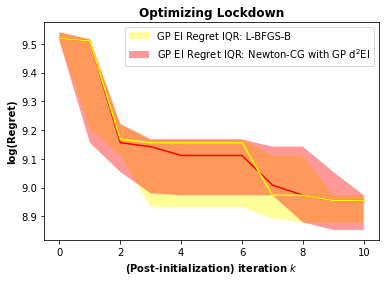

In [90]:
### Visualize!

title = obj_func

plt.figure()

plt.plot(median_loser, color = 'Red')
plt.plot(median_winner, color = 'Yellow')

xstar = np.arange(0, max_iter+1, step=1)
plt.fill_between(xstar, lower_winner, upper_winner, facecolor = 'Yellow', alpha=0.4, label='GP EI Regret IQR: L-BFGS-B')
plt.fill_between(xstar, lower_loser, upper_loser, facecolor = 'Red', alpha=0.4, label='GP EI Regret IQR: Newton-CG with GP d$^{2}$EI')

plt.title(title, weight = 'bold')
plt.xlabel('(Post-initialization) iteration $\it{k}$', weight = 'bold', family = 'Arial') # x-axis label
plt.ylabel('log(Regret)', weight = 'bold', family = 'Arial') # y-axis label
plt.legend(loc=1) # add plot legend

plt.show() #visualize

In [91]:
## 'Loser' and 'Winner' are terms used to differentiate between the 1st surrogate vs. 2nd surrogate 

## In this example the 'Loser' surrogate i.e. Newton-CG + Exact Hessian minimizes training regret IQR versus the 'winner' i.e. L-BFGS-B

In [92]:
lower_winner11, median_winner11, upper_winner11

(8.973097896282471, 8.955060950631902, 8.878776071707552)

In [93]:
y_low_win = np.exp(lower_winner11)
y_median_win = np.exp(median_winner11)
y_upper_win = np.exp(upper_winner11)

y_low_win, y_median_win, y_upper_win

(7888.000000000001, 7746.999999999994, 7177.999999999996)

In [94]:
f_syn_polarity(0.5683654)

## x = 56.84 days corresponds to the median training regret of y = 7,747 daily cases

7747.0

In [95]:
lower_loser11, median_loser11, upper_loser11

(8.973097896282471, 8.955060950631902, 8.852521917335372)

In [96]:
y_low_lose = np.exp(lower_loser11)
y_median_lose = np.exp(median_loser11)
y_upper_lose = np.exp(upper_loser11)

y_low_lose, y_median_lose, y_upper_lose

(7888.000000000001, 7746.999999999994, 6992.000000000001)

In [97]:
f_syn_polarity(0.5683654)

## x = 56.84 days corresponds to the median training regret of y = 7,747 daily cases

7747.0

In [98]:
time_lose, time_win

(1429.9792416095734, 1247.4514355659485)